![Alt text](new.png)

# Calculate reference stress for each temperature at each strain rate

For each condition, calculate take the stress where strain is smaller than 0.08 and divide it by the reference stress at 298.15K

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from itertools import product  # Import product for grid search

# Method 2: group proposed equation based on student equation

In [21]:
# Define the Polynomial-Log Hybrid Model
def strain_rate_dependent_stress(sr, C1, C2, C3, C4):
    return C1 * np.log(sr) + C2 * sr**C3 + C4 * (np.log(sr))**2

def fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns):
    # Load the temperature-specific file
    data = pd.read_csv(f"../{temperature_file}.csv")
    
    # Default rows to plot
    plot_indices = [2,3,4,54,60]
    
    # Define a scaling factor for better readability in the plot legend
    scale_factor = 1

    # List to store the results
    results = []

    # Loop through all rows in the dataset for strain-rate dependency fitting
    for i in range(len(data)):

        # Extract stress data for other strain rates
        stress_values = data.iloc[i][strain_rate_columns]
        
        # Initial guess and bounds for C1, C2, C3, and C4
        initial_guess_sr = [0.1, 0.1, 0.1, 0.1] 
        
        # Perform the curve fitting
        try:
            params_sr, _ = curve_fit(
                lambda sr, C1, C2, C3, C4: strain_rate_dependent_stress(sr, C1, C2, C3, C4),
                strain_rates, stress_values, p0=initial_guess_sr, maxfev=10000000, method='dogbox'
            )
        except RuntimeError:
            print(f"Could not fit strain-rate dependency for row {i}")
            continue
        
        # Calculate residuals and R-squared
        stress_fit = strain_rate_dependent_stress(strain_rates, *params_sr)
        residuals = stress_values - stress_fit
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((stress_values - np.mean(stress_values))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Store results for exporting
        results.append({
            "PEEQ": data['strain'].iloc[i],
            "C1": params_sr[0],
            "C2": params_sr[1],
            "C3": params_sr[2],
            "C4": params_sr[3],
            "R_squared": r_squared
        })
        
        # Plot only for specified rows with scaled C1, C2, C3, and C4 in legend
        if i in plot_indices:
            plt_strain_rates = np.linspace(min(strain_rates), max(strain_rates), 1000)
            plt_stress_fit = strain_rate_dependent_stress(plt_strain_rates, *params_sr)
            plt.plot(strain_rates, stress_values, 'o', label='Data')
            plt.plot(plt_strain_rates, plt_stress_fit, '-', label='Fit')  # Use only original strain rates for fit plot
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
            plt.legend([f'Row {i}', f'Fit: C1={params_sr[0] * scale_factor:.2f}, C2={params_sr[1] * scale_factor:.2f}, C3={params_sr[2] * scale_factor:.2f}, C4={params_sr[3] * scale_factor:.2f}'], loc="lower right")
            plt.grid()
            plt.show()

    # Export results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"Parameters_{temperature_file}_new.csv", index=False)


## Finding parameters

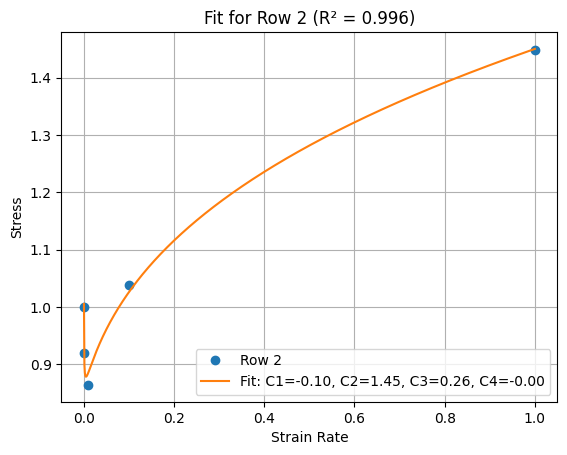

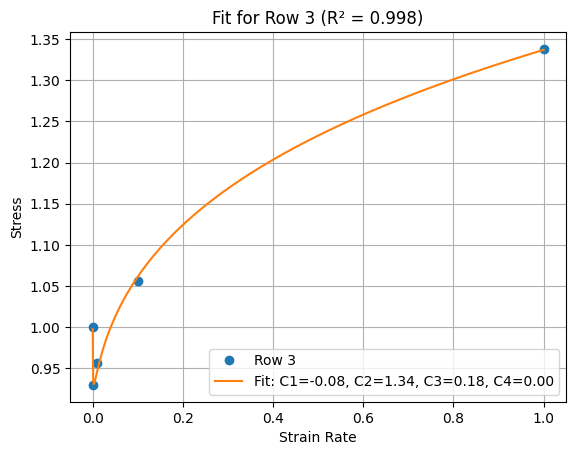

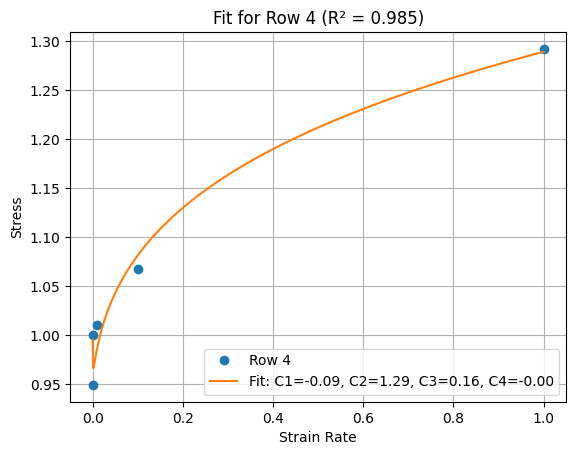

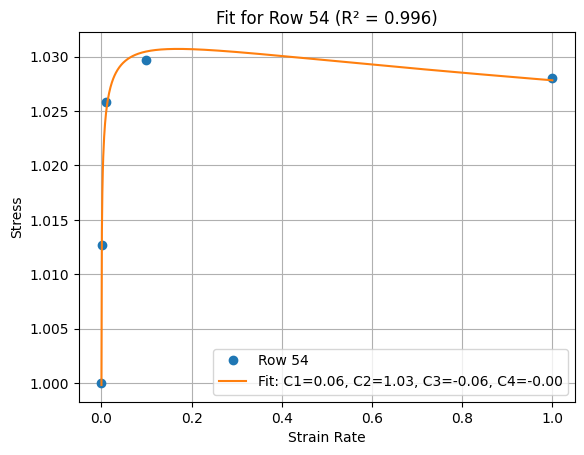

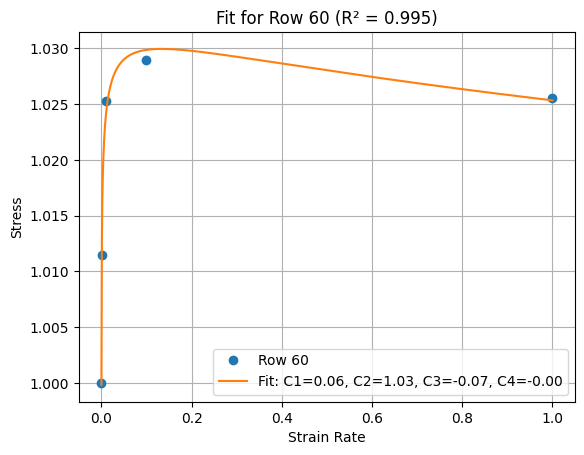

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


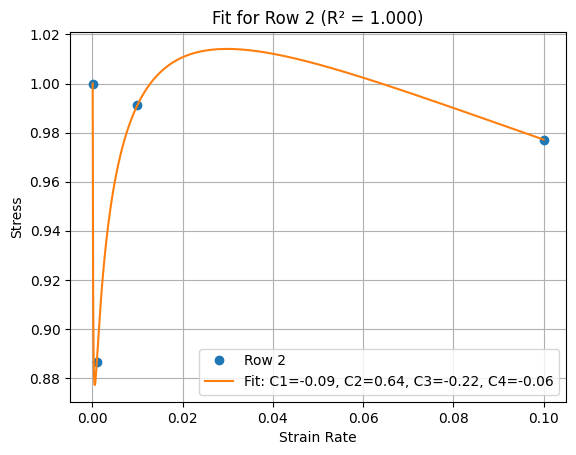

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


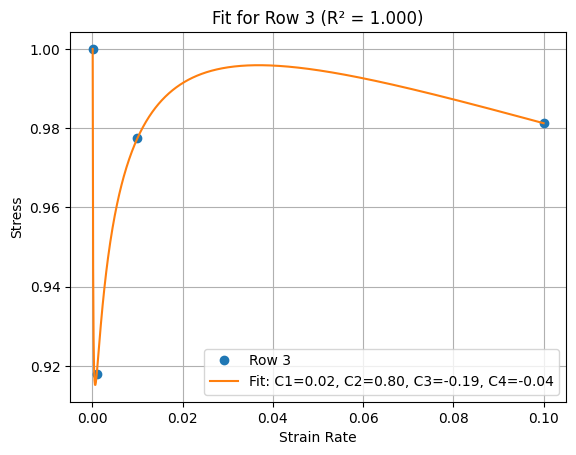

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


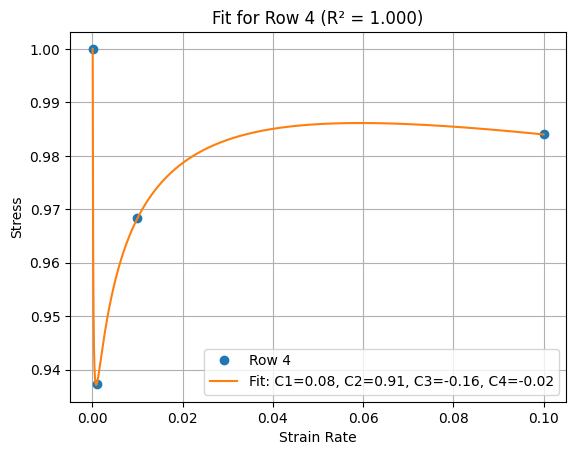

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

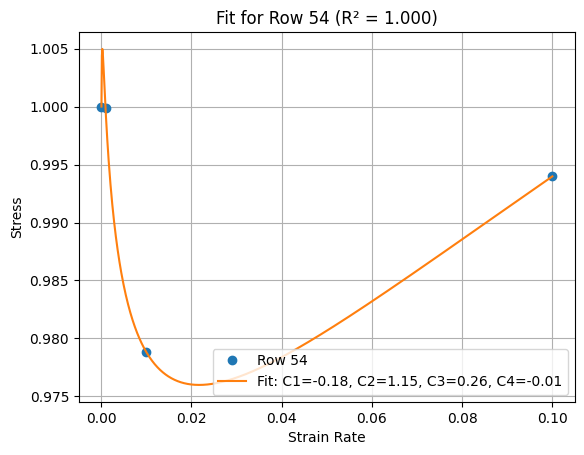

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


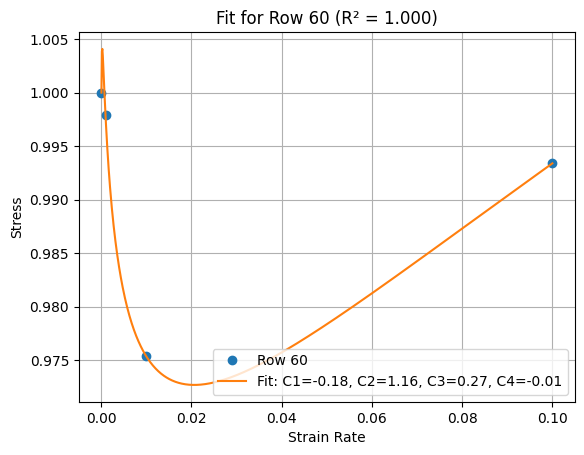

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

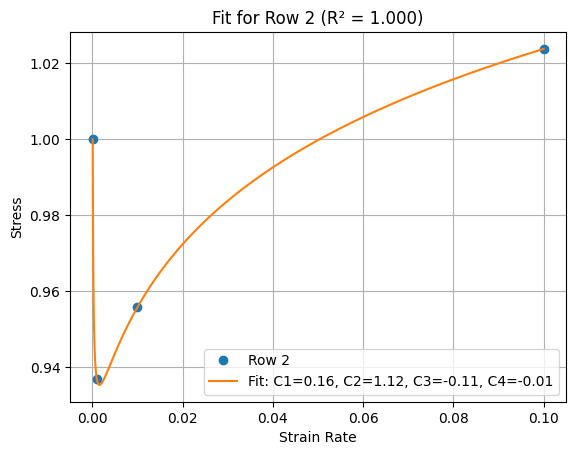

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


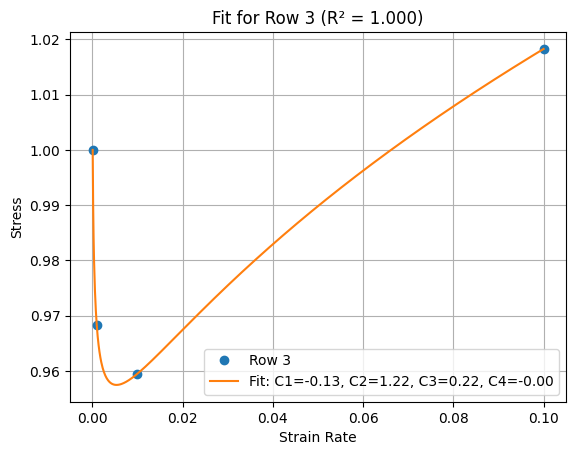

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


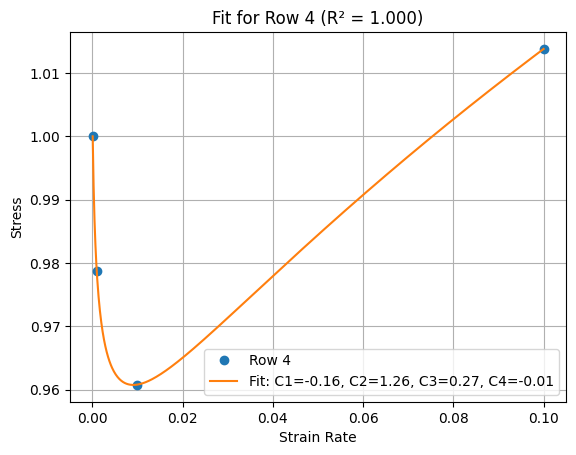

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

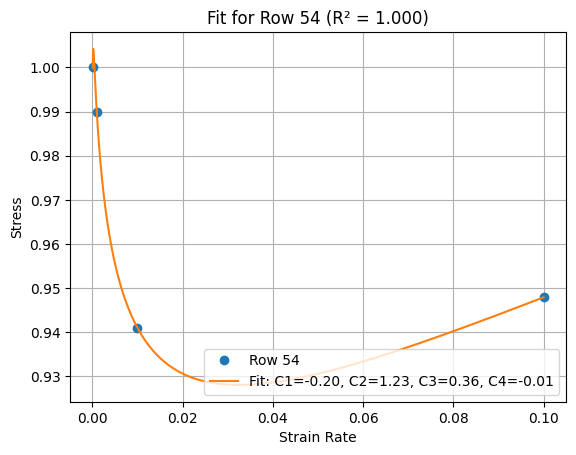

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


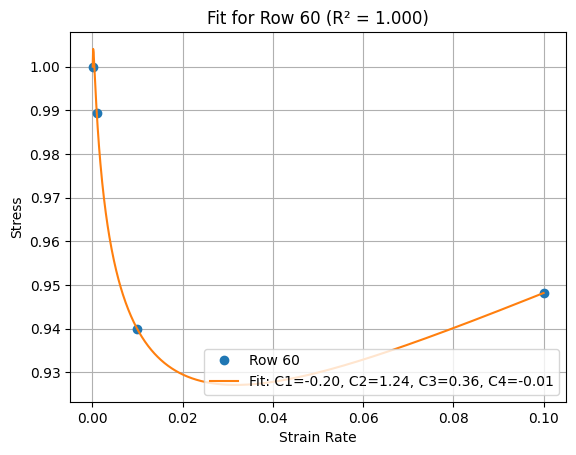

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

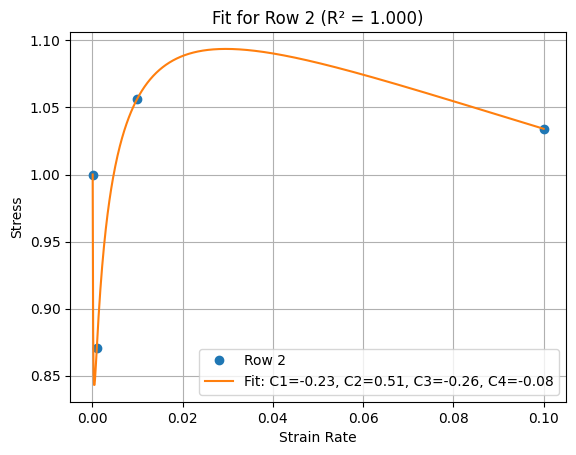

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


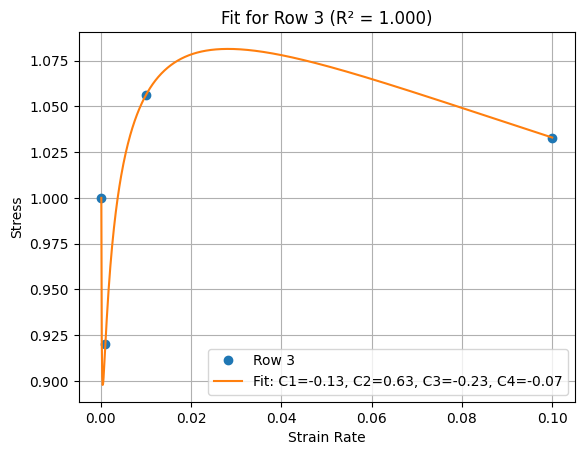

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


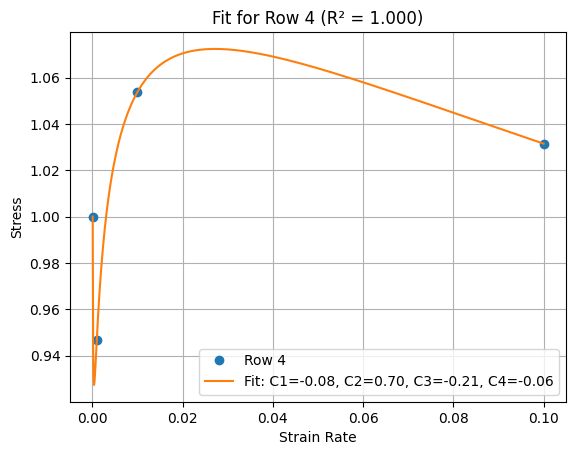

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

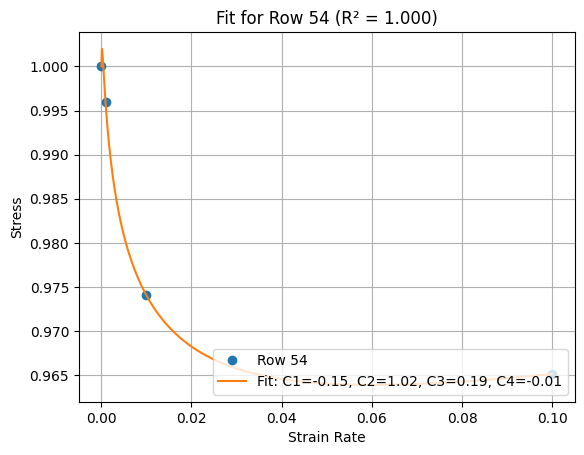

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


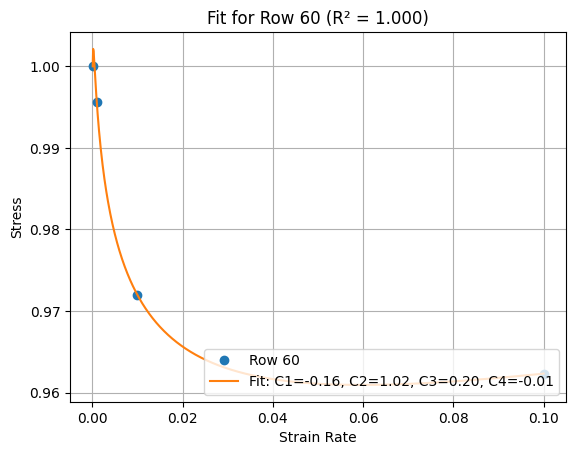

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

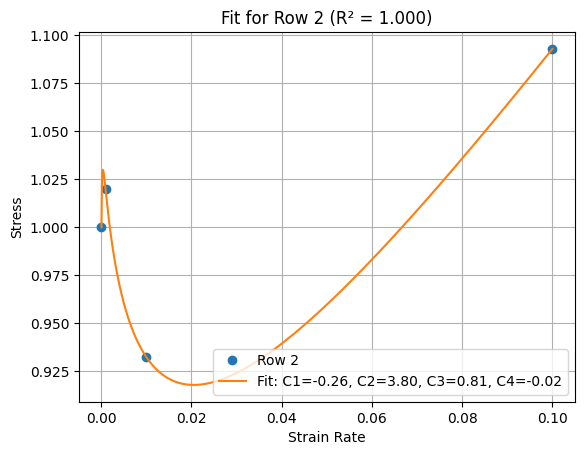

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


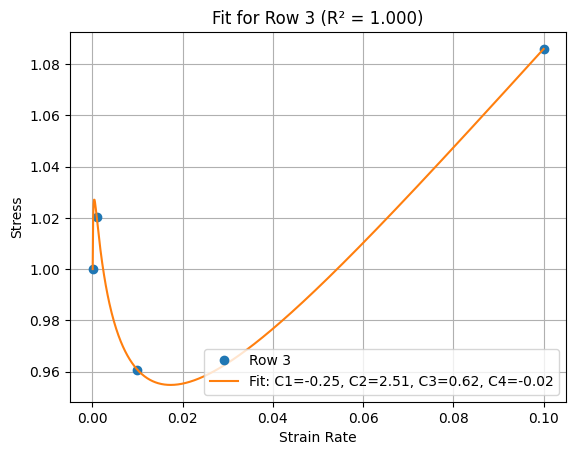

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


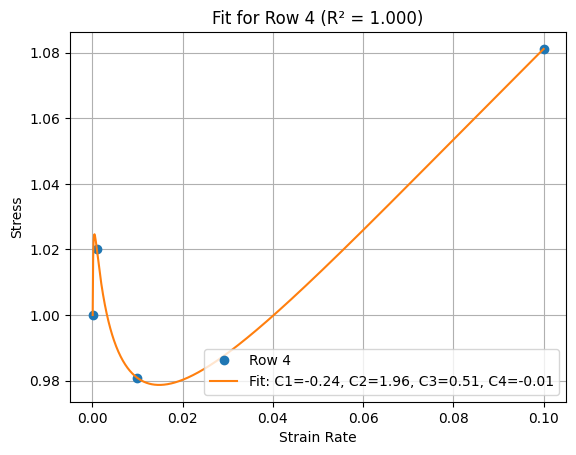

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

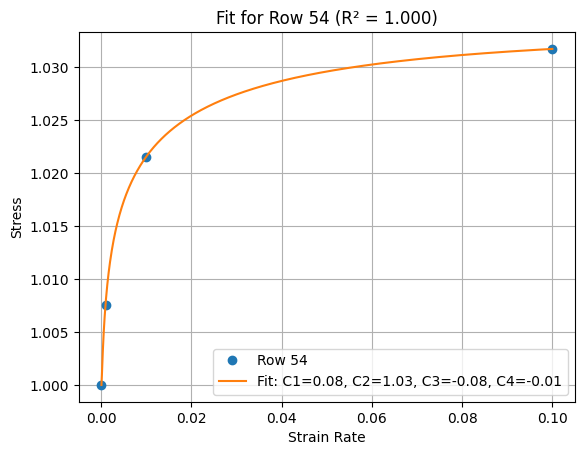

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(


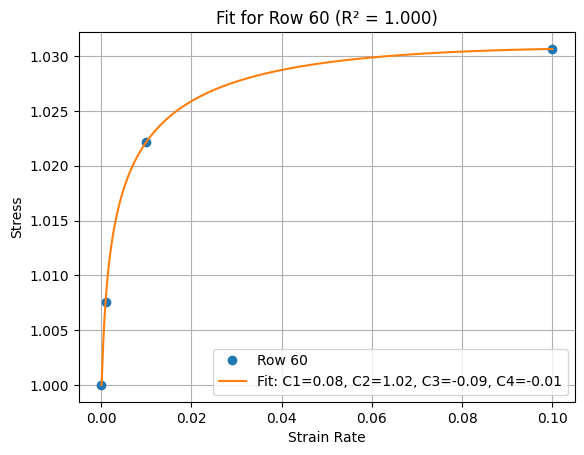

/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: Covariance of the parameters could not be estimated
  params_sr, _ = curve_fit(
/tmp/ipykernel_181675/55867328.py:29: OptimizeWarning: 

In [22]:

temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
temps = ['373.15', '473.15', '573.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    fit_strain_rate_dependency(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

temperature_file = 'Tmp673.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
fit_strain_rate_dependency(temperature_file, strain_rates, strain_rate_columns)

# Check R1 score
## Check to see if any R1 < 0.95

In [35]:
import pandas as pd

def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports the count
    and percentage of rows with R_squared below a specified threshold.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints the count and percentage of rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.95
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
        
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_low_r_squared = df[df['R_squared'] < threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_low_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_low_r_squared > 0:
            print(f"Number of rows with R_squared < {threshold}: {count_low_r_squared}")
            print(f"Percentage of rows with R_squared < {threshold}: {percentage_low_r_squared:.2f}%")
            #print(df[df['R_squared'] < threshold]['PEEQ'])
        else:
            print(f"All R_squared values are >= {threshold}.")

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
All R_squared values are >= 0.95.

Temperature File: Parameters_Tmp373.15_RD.csv
All R_squared values are >= 0.95.

Temperature File: Parameters_Tmp473.15_RD.csv
All R_squared values are >= 0.95.

Temperature File: Parameters_Tmp573.15_RD.csv
All R_squared values are >= 0.95.

Temperature File: Parameters_Tmp673.15_RD.csv
All R_squared values are >= 0.95.


# Calibrate C1, C2 based on strain dependent

## Study relationship between C1, C2
C1, C2 follows the same trend for a condition and is dependent on strain rate => Use the same strain dependent function

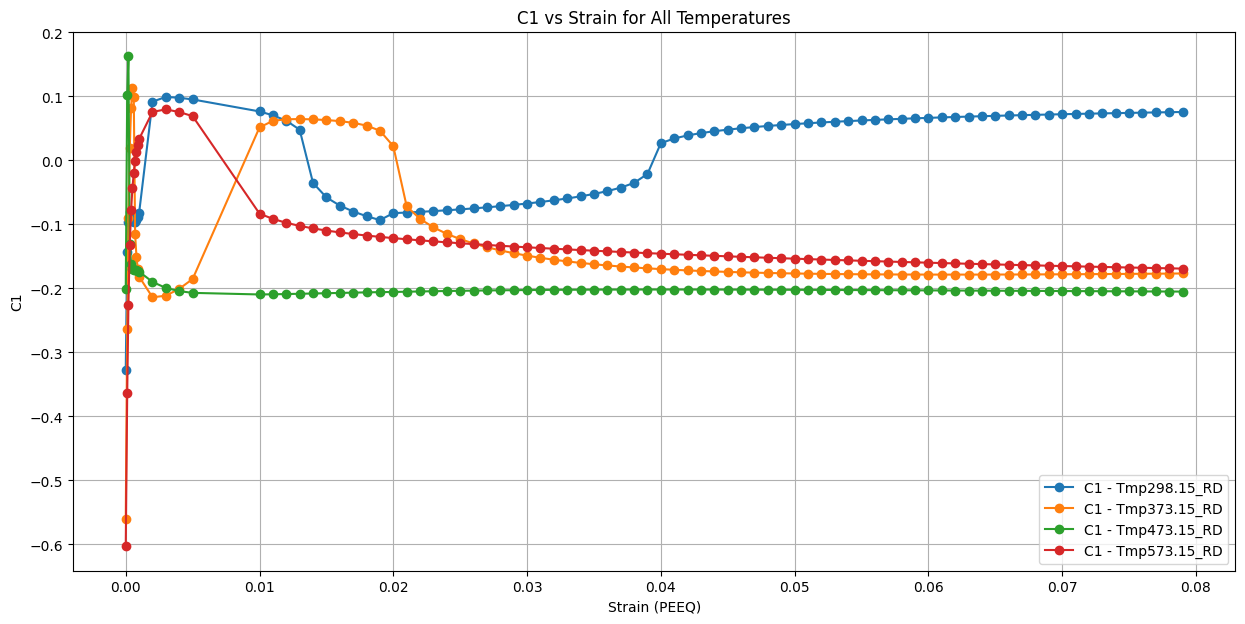

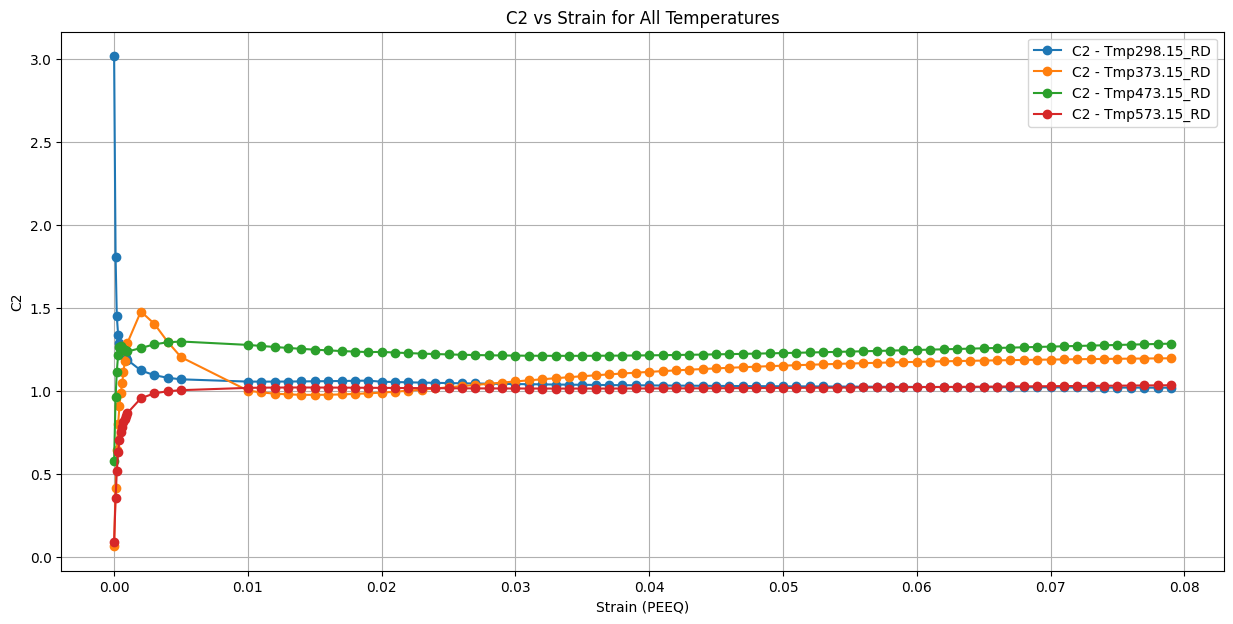

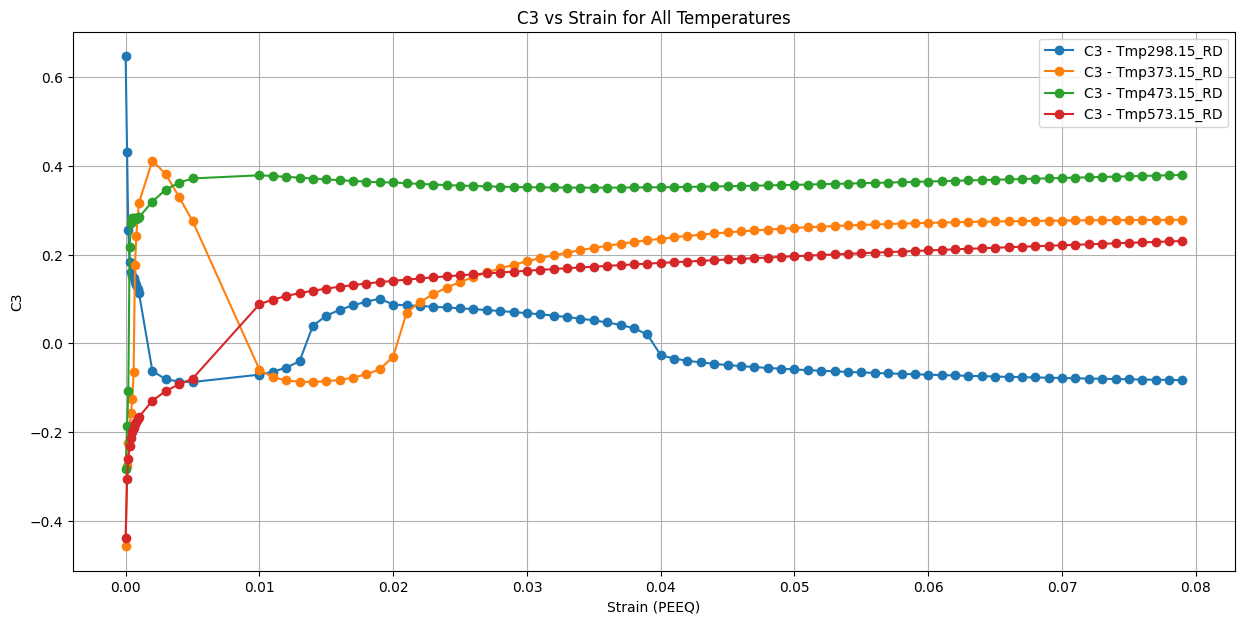

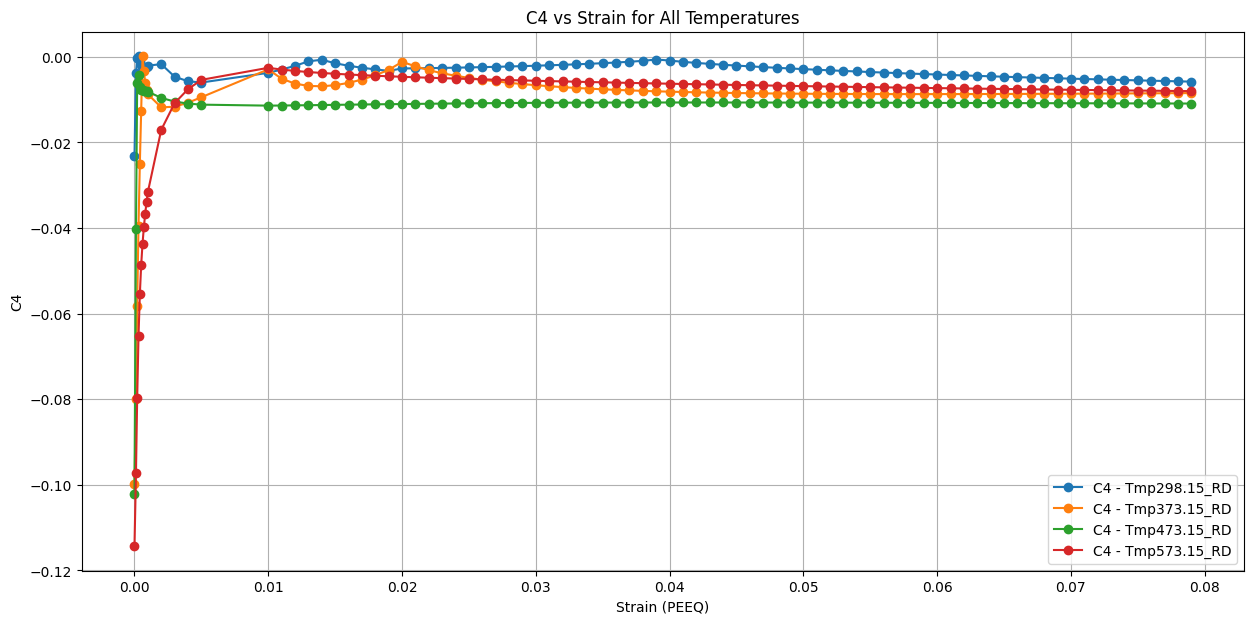

In [36]:
# List of temperature files to load
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD']

# Plot all C1 in one plot
plt.figure(figsize=(15, 7))
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
    # Plot C1 vs. strain
    plt.plot(df['PEEQ'], df['C1'], marker='o', label=f'C1 - {temp_file}')
plt.xlabel('Strain (PEEQ)')
plt.ylabel('C1')
plt.title('C1 vs Strain for All Temperatures')
plt.legend()
plt.grid()
plt.show()

# Plot all C2 in one plot
plt.figure(figsize=(15, 7))
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
    # Plot C2 vs. strain
    plt.plot(df['PEEQ'], df['C2'], marker='o', label=f'C2 - {temp_file}')
plt.xlabel('Strain (PEEQ)')
plt.ylabel('C2')
plt.title('C2 vs Strain for All Temperatures')
plt.legend()
plt.grid()
plt.show()

# Plot all C3 in one plot
plt.figure(figsize=(15, 7))
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
    # Plot C3 vs. strain
    plt.plot(df['PEEQ'], df['C3'], marker='o', label=f'C3 - {temp_file}')
plt.xlabel('Strain (PEEQ)')
plt.ylabel('C3')
plt.title('C3 vs Strain for All Temperatures')
plt.legend()
plt.grid()
plt.show()

# Plot all C4 in one plot
plt.figure(figsize=(15, 7))
for temp_file in temperature_files:
    # Load the data from the CSV file
    df = pd.read_csv(f"Parameters_{temp_file}_new.csv")
    # Plot C4 vs. strain
    plt.plot(df['PEEQ'], df['C4'], marker='o', label=f'C4 - {temp_file}')
plt.xlabel('Strain (PEEQ)')
plt.ylabel('C4')
plt.title('C4 vs Strain for All Temperatures')
plt.legend()
plt.grid()
plt.show()


## Calibrate strain dependent function for C1 and C2

In [37]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}_new.csv")  # Replace with your actual file path
    strain = data['PEEQ']  # Strain values
    C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values
    C3_values = data['C3']  # C1 values
    C4_values = data['C4']  # C2 values

    # Define the stretched exponential model
    def C1_func(x, a1, b1, c1, d1, a2, b2, c2, d2, a3,b3,c3, threshold1=0.002, threshold2=0.02):
        small_strain = a1*x**3 + b1*x**2 + c1*x + d1
        middle_strain = a2*x**3 + b2*x**2 + c2*x + d2
        high_strain = a3*x**2 + b3*x + c3
        # Piecewise combination based on thresholds
        return np.where(
            x <= threshold1, small_strain,
            np.where(x <= threshold2, middle_strain, high_strain)
        )
        #return e*epsilon**4 +  a*epsilon**3 + b*epsilon**2 + c*epsilon + d


    def C2_func(x, a, b, c, d, e):
        epsilon = 1e-6
        x_shifted = x + epsilon
        return a * np.log(x_shifted) + b * x_shifted**c + d * np.exp(-e * x_shifted)
    

    def C3_func(x, a1, b1, c1, d1, a2, b2, c2, d2, a3,b3,c3, threshold1=0.002, threshold2=0.02):
        small_strain = a1*x**3 + b1*x**2 + c1*x + d1
        middle_strain = a2*x**3 + b2*x**2 + c2*x + d2
        high_strain = a3*x**2 + b3*x + c3
        # Piecewise combination based on thresholds
        return np.where(
            x <= threshold1, small_strain,
            np.where(x <= threshold2, middle_strain, high_strain)
        )
    

    def C4_func(x, a1, b1, c1, d1, a2, b2, c2, a3, b3, c3,d3, e3,f3,g3, threshold1=0.002, threshold2=0.04):
        # Low strain: Oscillatory component
        small_strain = a1 * np.exp(b1 * x) * np.cos(c1 * x) + d1
        
        # Middle strain: Oscillatory component for waves
        middle_strain = a3 * np.sin(b3 * x + c3) * np.exp(-d3 * x) + e3 * x**2 + f3 * x + g3 
        
        # High strain: Stable behavior
        high_strain = a2 * np.exp(b2 * x) + c2
        
        # Piecewise combination based on thresholds
        return np.where(
            x <= threshold1, small_strain,
            np.where(x <= threshold2, middle_strain, high_strain)
        )

    initial_guess_C1 = [1,1,1,1,1,1,1,1,1,1,1]
    initial_guess_C2 = [1,1,1,1,1] 
    initial_guess_C3 = [1,1,1,1,1,1,1,1,1,1,1]
    initial_guess_C4 = [-0.1, -1000, 1000, 0, -0.01, -50, 0.01, 0.1, 1.0, 0.0, 0.1, 0.0, 1.0, 0.0]
    # Fit the stretched exponential model to C1
    popt_C1, _ = curve_fit(C1_func, strain, C1_values, p0=initial_guess_C1, maxfev=10000000)
    popt_C2, _ = curve_fit(C2_func, strain, C2_values, p0=initial_guess_C2, maxfev=10000000)
    popt_C3, _ = curve_fit(C3_func, strain, C3_values, p0=initial_guess_C3,maxfev=10000000)
    popt_C4, _ = curve_fit(C4_func, strain, C4_values, p0=initial_guess_C4, maxfev=10000000)


    # Generate fitted values using the stretched exponential model
    C1_fit = C1_func(strain, *popt_C1)
    C2_fit = C2_func(strain, *popt_C2)
    C3_fit = C3_func(strain, *popt_C3)
    C4_fit = C4_func(strain, *popt_C4)

    fitted_df = pd.DataFrame({
        'strain': strain,
        'C1': C1_fit,
        'C2': C2_fit,
        'C3': C3_fit,
        'C4': C4_fit
    })
    fitted_df.to_csv(f"Fitted_Parameters_{temp_file}.csv", index=False)

    # Calculate R^2 scores
    C_values = {'C1': C1_values, 'C2': C2_values, 'C3': C3_values, 'C4': C4_values}
    C_fits = {'C1': C1_fit, 'C2': C2_fit, 'C3': C3_fit, 'C4': C4_fit}
    r2_scores = {}

    for key in C_values:
        residuals = C_values[key] - C_fits[key]
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((C_values[key] - np.mean(C_fits[key]))**2)
        r2_scores[key] = 1 - (ss_res / ss_tot)

    
    # Plot C1 vs Strain 
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C1_values, 'o', label='C1 Data')
    plt.plot(strain, C1_fit, '-', label='C1 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C1')
    plt.legend()
    plt.title(f"C1 vs Strain {temp_file} (R^2: {r2_scores['C1']:.3f})")
    plt.show()

    # Plot C2 vs Strain 
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C2_values, 'o', label='C2 Data')
    plt.plot(strain, C2_fit, '-', label='C2 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain {temp_file} (R^2: {r2_scores['C2']:.3f})")
    plt.show()

    # Plot C3 vs Strain 
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C3_values, 'o', label='C3 Data')
    plt.plot(strain, C3_fit, '-', label='C3 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C3')
    plt.legend()
    plt.title(f"C3 vs Strain {temp_file} (R^2: {r2_scores['C3']:.3f})")
    plt.show()
    
     # Plot C4 vs Strain
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C4_values, 'o', label='C4 Data')
    plt.plot(strain, C4_fit, '-', label='C4 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C4')
    plt.legend()
    plt.title(f"C4 vs Strain Fit {temp_file} (R^2: {r2_scores['C4']:.3f})")
    plt.show()

    # Print the fitted parameters for reference
    print("Parameters for C1:", popt_C1)
    print("Parameters for C2:", popt_C2)
    print("Parameters for C3:", popt_C3)
    print("Parameters for C4:", popt_C4)


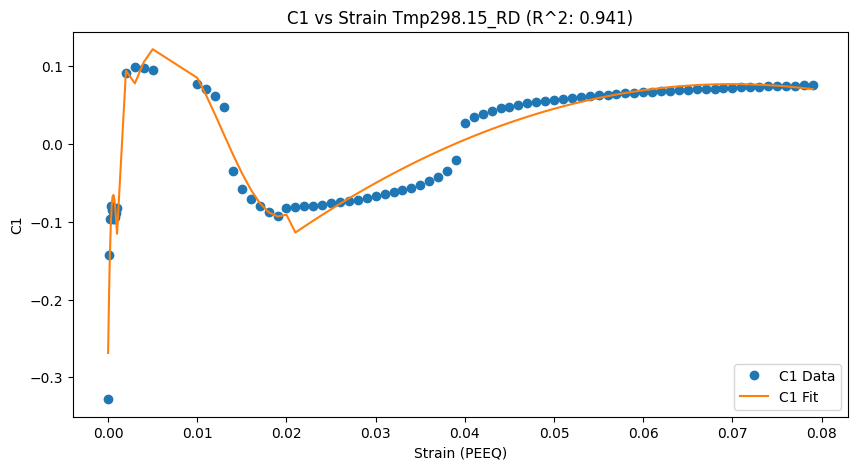

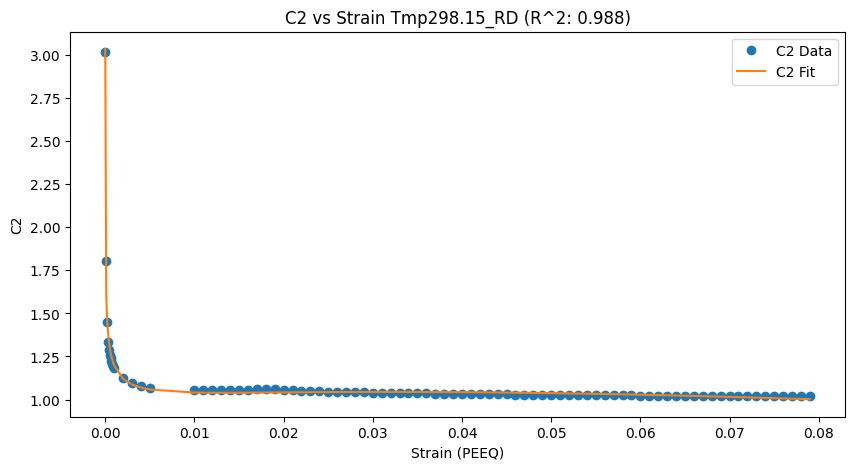

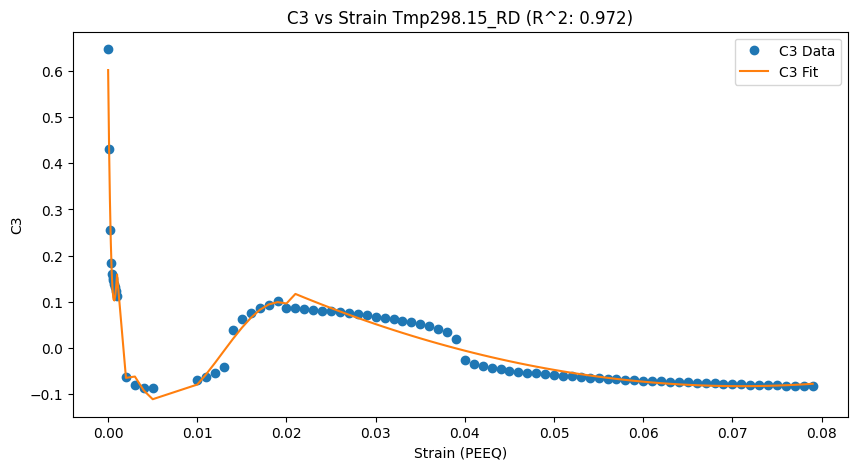

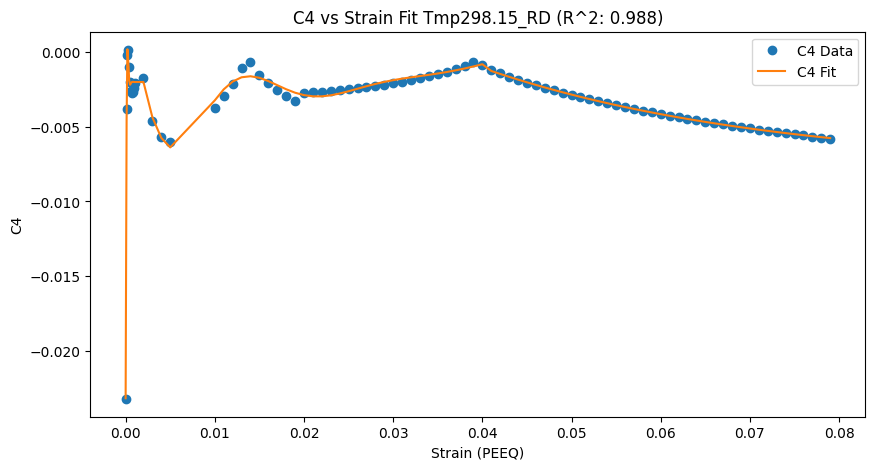

Parameters for C1: [ 3.50784099e+08 -1.02428394e+06  8.26852234e+02 -2.68666103e-01
  2.06276292e+05 -7.90169459e+03  7.50602039e+01 -8.16830616e-02
 -7.95953903e+01  1.11373742e+01 -3.12607840e-01]
Parameters for C2: [-0.46198126  6.38244564  0.17021521 -3.95772104 -1.0905849 ]
Parameters for C3: [-6.08701287e+08  1.93561501e+06 -1.76986926e+03  6.01926541e-01
 -2.15977938e+05  8.30650676e+03 -8.04426264e+01  1.10339565e-01
  7.98795274e+01 -1.13451300e+01  3.19937232e-01]
Parameters for C4: [-2.11805510e-02 -9.09783016e+03 -1.13244063e+04 -1.99799030e-03
  2.32068517e-02 -3.10914386e+01 -7.74425470e-03 -8.31895167e-03
 -3.73047305e+02  3.93150000e+00  1.35505912e+02  2.72203855e+00
 -6.84792739e-02 -2.38633787e-03]


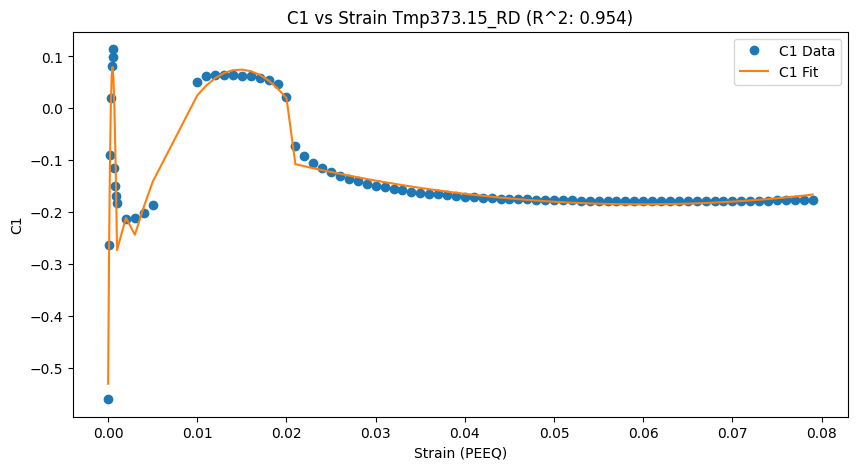

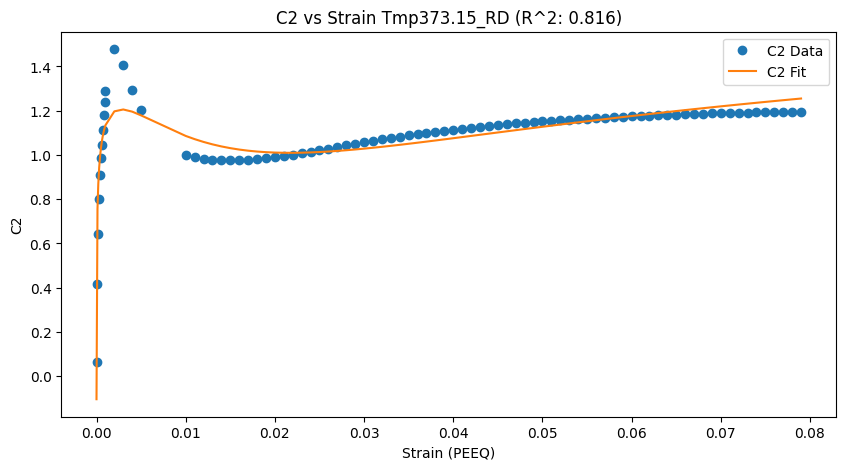

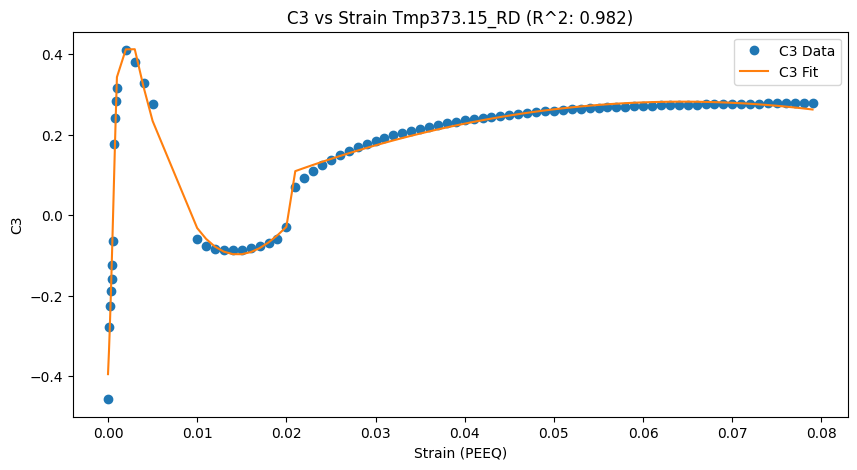

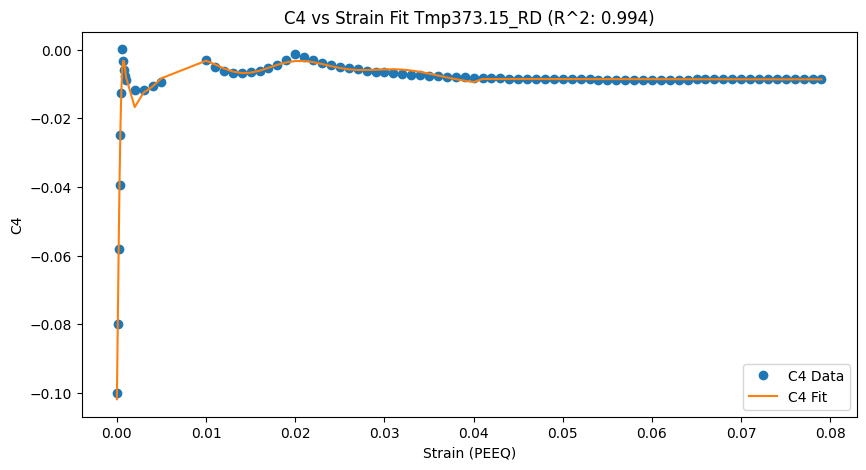

Parameters for C1: [ 1.21766009e+09 -3.75050570e+06  2.79003909e+03 -5.29771809e-01
  1.64671744e+04 -2.82811085e+03  7.27814497e+01 -4.36404488e-01
  5.10239252e+01 -6.11149864e+00 -1.55547083e-03]
Parameters for C2: [  0.12019012   2.0838832    0.11418027   1.125858   101.60024182]
Parameters for C3: [-3.02750522e+08  5.73678788e+05  4.67216807e+02 -3.94994777e-01
 -9.12719300e+04  6.76519528e+03 -1.38759880e+02  7.70357031e-01
 -9.15894493e+01  1.17999911e+01 -9.78856187e-02]
Parameters for C4: [-8.58219669e-02 -2.29876283e+03  3.43924042e+03 -1.59990655e-02
 -1.21161671e-01  2.48174533e-02  1.12754919e-01  6.36716570e-03
  5.16765864e+02 -9.21634964e+00  7.80758805e+01 -1.11189277e+01
  4.33578356e-01 -8.72980269e-03]


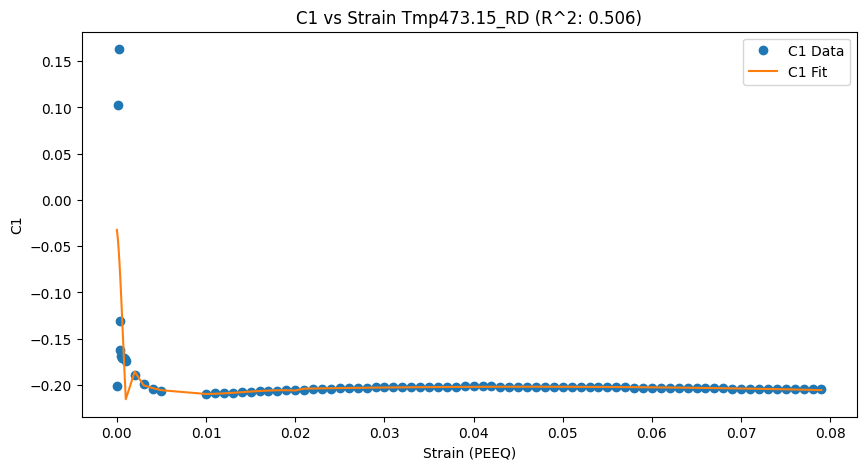

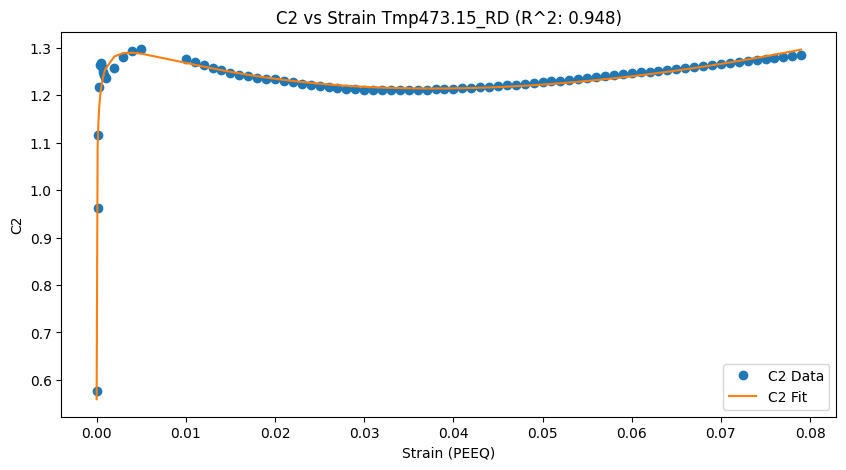

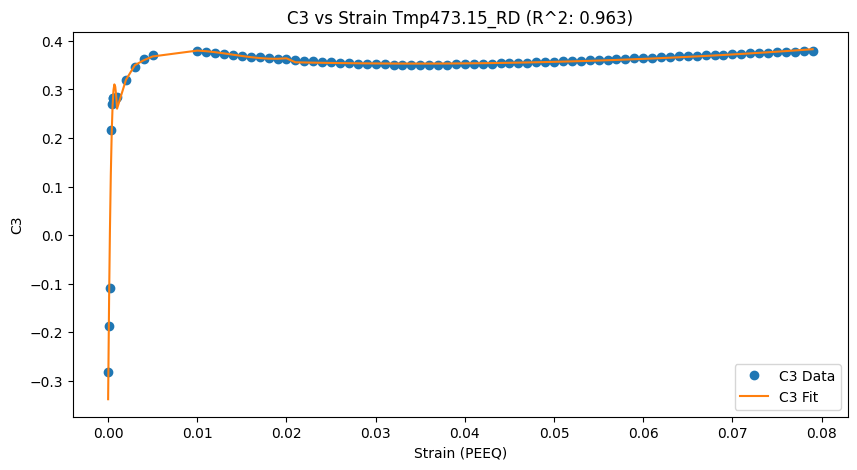

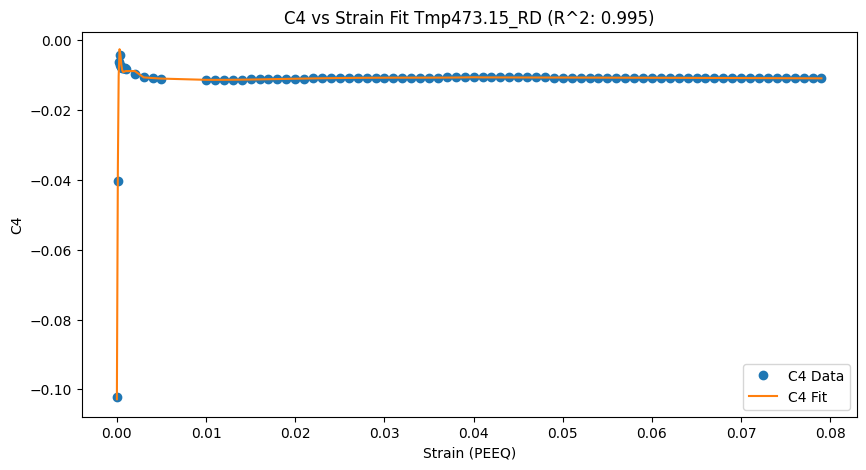

Parameters for C1: [ 1.12519428e+08 -2.31135728e+05 -6.44459799e+01 -3.23744303e-02
 -1.07718890e+04  4.56836782e+02 -5.78447485e+00 -1.86844613e-01
 -3.31174058e+00  3.04158772e-01 -2.08923911e-01]
Parameters for C2: [ 0.12365994 -4.69116631  0.47880395  2.27385476 -3.51524093]
Parameters for C3: [ 6.33581500e+08 -2.17011735e+06  2.13477619e+03 -3.37956146e-01
  3.92636221e+04 -1.64083837e+03  2.01501035e+01  3.03250432e-01
  1.49109754e+01 -1.02738822e+00  3.70852513e-01]
Parameters for C4: [-9.39891537e-02 -7.50660606e+03 -7.51742528e+03 -8.83364262e-03
 -1.18058286e-04  1.89496685e+01 -1.03939092e-02  1.18696640e+00
 -1.88401471e+01  1.30456969e+00 -4.82975971e+00  2.43939232e+02
  6.06026843e-03 -1.15497174e+00]


/tmp/ipykernel_181675/435805906.py:63: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_C4, _ = curve_fit(C4_func, strain, C4_values, p0=initial_guess_C4, maxfev=10000000)


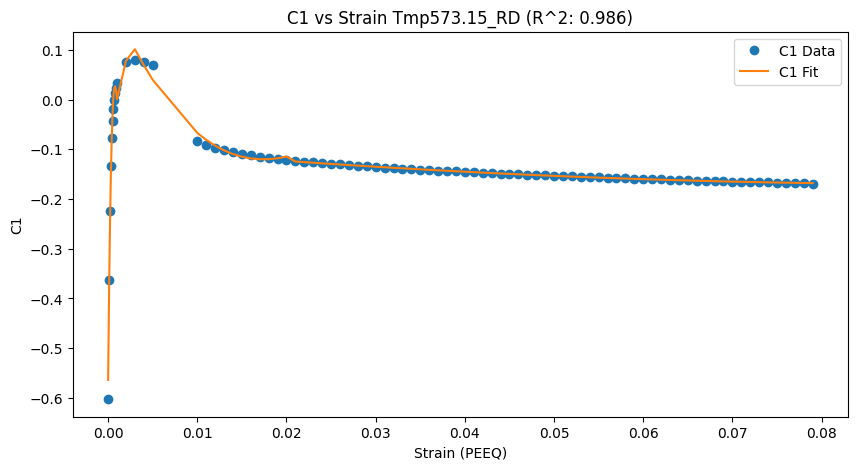

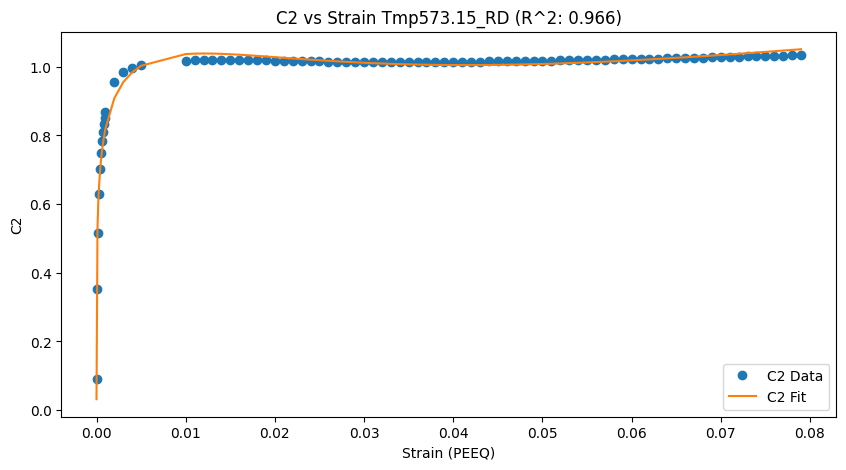

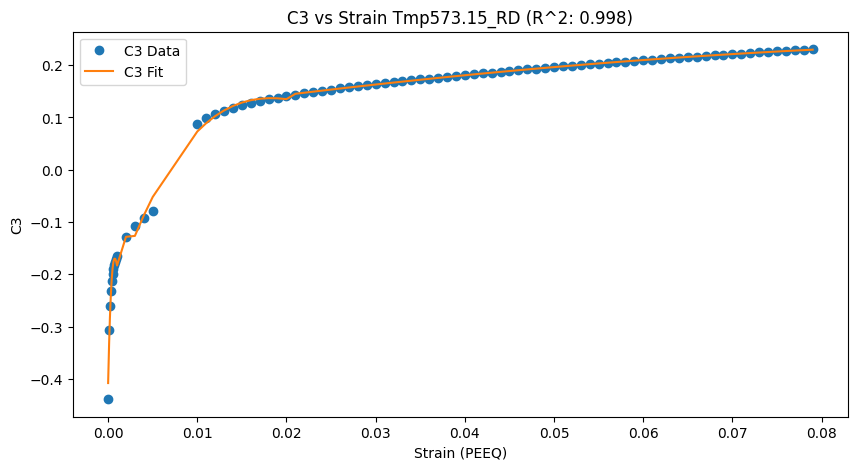

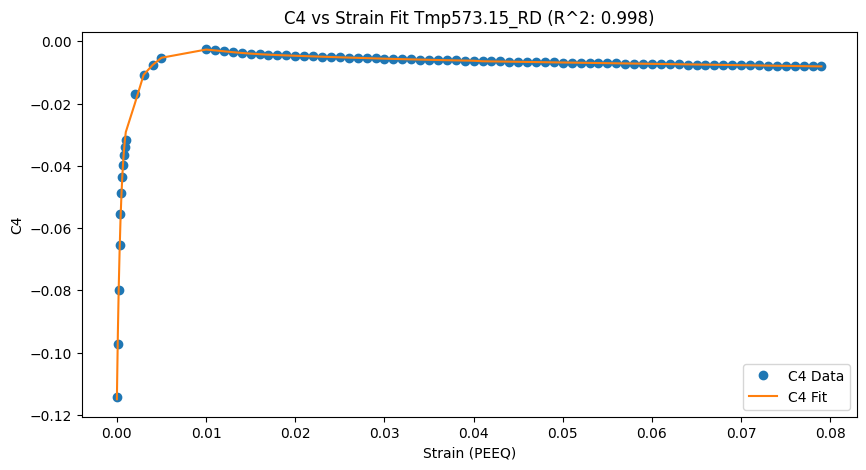

Parameters for C1: [ 5.19041839e+08 -1.80072018e+06  1.84610856e+03 -5.63880534e-01
 -1.43946755e+04  1.61024023e+03 -4.29839009e+01  2.15992012e-01
  8.52906636e+00 -1.60140840e+00 -9.47970288e-02]
Parameters for C2: [ 0.06365597  1.87343815  0.18582299  0.76747787 36.28348672]
Parameters for C3: [ 2.29294243e+08 -7.72858036e+05  7.68383917e+02 -4.07967516e-01
  2.83644728e+04 -2.25060690e+03  5.38489530e+01 -2.68575086e-01
 -1.05547799e+01  2.51023607e+00  9.72219291e-02]
Parameters for C4: [-9.58498870e-02 -2.25537958e+03 -1.17487862e-02 -1.91048806e-02
 -2.09356428e+00  2.07753248e-02  2.08891569e+00  2.39945306e-02
 -3.25196387e+02  5.38753718e+00  3.33235687e+02  1.43700155e+00
 -1.67404236e-01 -1.86511152e-03]


/tmp/ipykernel_181675/435805906.py:61: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_C2, _ = curve_fit(C2_func, strain, C2_values, p0=initial_guess_C2, maxfev=10000000)
/root/coe-final-project/myenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


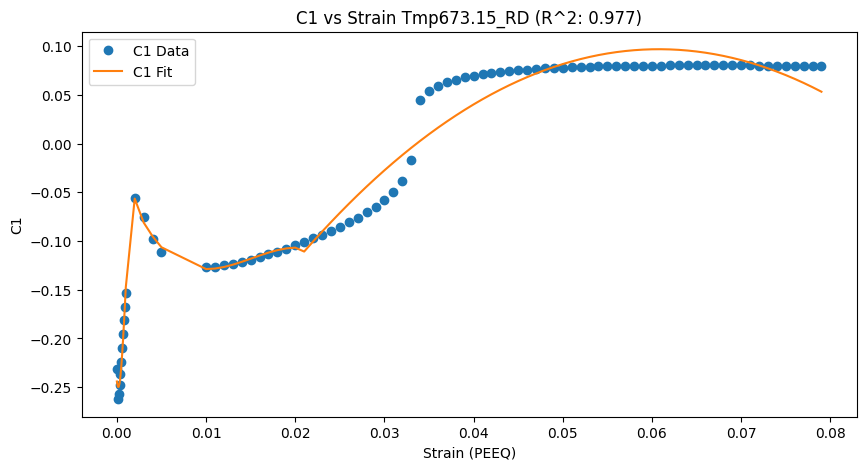

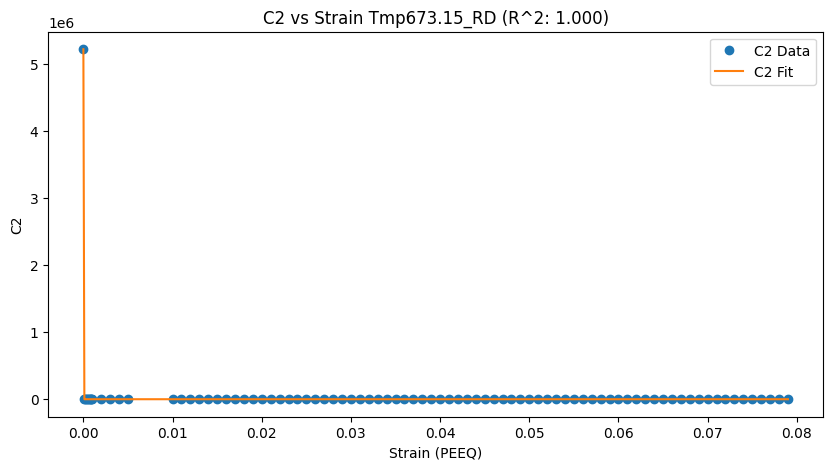

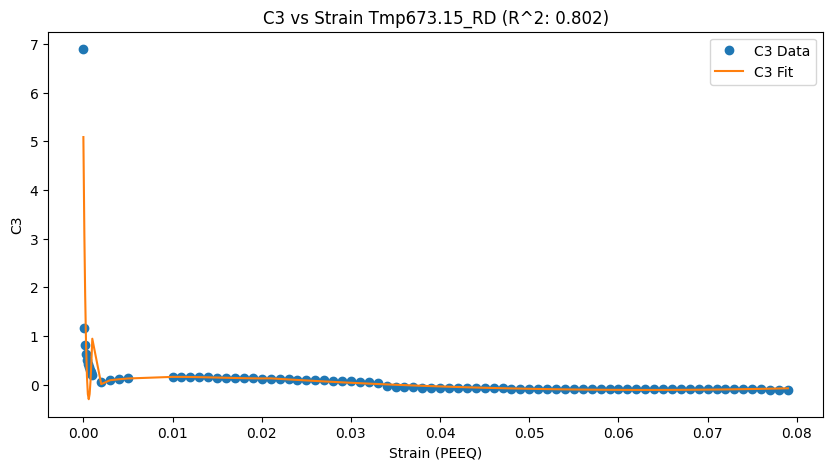

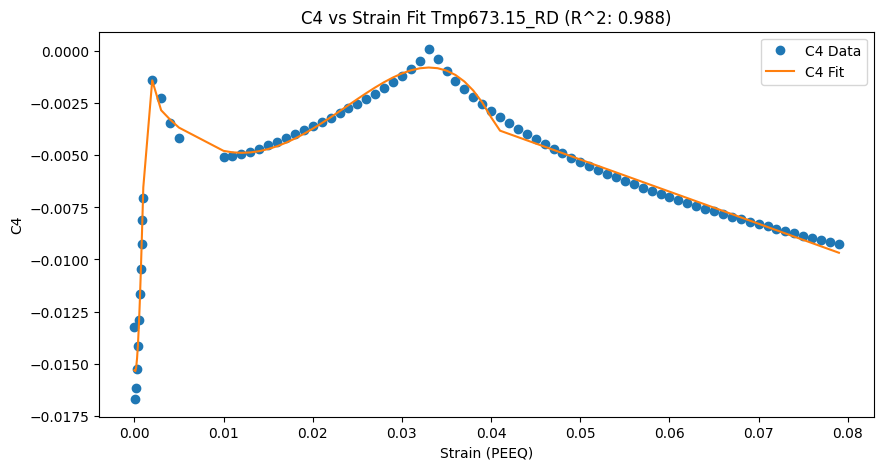

Parameters for C1: [-8.81261023e+07  2.61527643e+05 -7.66687300e+01 -2.44219005e-01
 -4.30380202e+04  1.95141531e+03 -2.62154801e+01 -1.87647303e-02
 -1.31314428e+02  1.59606294e+01 -3.88113304e-01]
Parameters for C2: [-2.79630397e-01 -1.71463955e+01  1.18625858e+06  5.91711078e+06
  1.24275902e+05]
Parameters for C3: [-7.48272362e+09  2.40521979e+07 -2.07104810e+04  5.08503299e+00
  5.67341160e+04 -2.63423800e+03  3.61650172e+01  5.05307699e-03
  1.33285527e+02 -1.68481993e+01  4.24705661e-01]
Parameters for C4: [-6.09515909e-03  2.57511311e+02  1.91899486e+03 -9.22756603e-03
 -1.17689033e+00  1.30045051e-01  1.17936645e+00  1.89309732e-02
  2.44626070e-02 -6.43637053e+00 -7.08242513e+01  3.88354258e+01
 -4.57183069e-01  1.75831235e-03]


In [38]:
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    calibrate_strain_dependent(temp_file)

In [ ]:
def calibrate_strain_dependent(temp_file):
    data = pd.read_csv(f"Parameters_{temp_file}_new.csv")  # Replace with your actual file path
    strain = data['PEEQ']  # Strain values
    # C1_values = data['C1']  # C1 values
    C2_values = data['C2']  # C2 values
    # C3_values = data['C3']  # C3 values
    # C4_values = data['C4']  # C4 values

    # Define the stretched exponential model
    # def C1_func(epsilon, a, b, c, d, e):
    #     return e * epsilon**4 + a * epsilon**3 + b * epsilon**2 + c * epsilon + d

   
    def C2_func(x, a, b, c, d, e, f, g):
        epsilon = 1e-6
        x_shifted = x + epsilon
        return (
            a * np.log(x_shifted) + 
            b * x_shifted**c + 
            d * np.exp(-e * x_shifted) + 
            f * np.exp(-((x - g)**2) / (2 * e**2))
        )
    
    
    # def C3_func(x, a1, b1, c1, d1, a2, b2, c2, d2, a3, b3, c3, threshold1=0.002, threshold2=0.02):
    #     small_strain = a1 * x**3 + b1 * x**2 + c1 * x + d1
    #     middle_strain = a2 * x**3 + b2 * x**2 + c2 * x + d2
    #     high_strain = a3 * x**2 + b3 * x + c3
    #     return np.where(
    #         x <= threshold1, small_strain,
    #         np.where(x <= threshold2, middle_strain, high_strain)
    #     )

    # def C4_func(x, a1, b1, c1, d1, a2, b2, c2, a3, b3, c3, d3, e3, f3, g3, threshold1=0.002, threshold2=0.04):
    #     small_strain = a1 * np.exp(b1 * x) * np.cos(c1 * x) + d1
    #     middle_strain = a3 * np.sin(b3 * x + c3) * np.exp(-d3 * x) + e3 * x**2 + f3 * x + g3
    #     high_strain = a2 * np.exp(b2 * x) + c2
    #     return np.where(
    #         x <= threshold1, small_strain,
    #         np.where(x <= threshold2, middle_strain, high_strain)
    #     )

    #initial_guess_C2 = [0.1, 1, 0.5, 0.1, 0.01] 
    #initial_guess_C2 = [1, 10, 0.2, 0.1, 0.5]
    initial_guess_C2 = [1, 10, 0.5, 1, 0.1, 1, 0.01]
    # initial_guess_C3 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
    # initial_guess_C4 = [-0.1, -1000, 1000, 0, -0.01, -50, 0.01, 0.1, 1.0, 0.0, 0.1, 0.0, 1.0, 0.0]

    # Fit the stretched exponential model to C2
    popt_C2, _ = curve_fit(C2_func, strain, C2_values, p0=initial_guess_C2, maxfev=10000000)

    # Generate fitted values using the stretched exponential model
    C2_fit = C2_func(strain, *popt_C2)

    fitted_df = pd.DataFrame({
        'strain': strain,
        'C2': C2_fit
    })
    fitted_df.to_csv(f"Fitted_Parameters_{temp_file}.csv", index=False)

    # Calculate R^2 score for C2
    residuals = C2_values - C2_fit
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((C2_values - np.mean(C2_values))**2)
    r2_score_C2 = 1 - (ss_res / ss_tot)

    # Plot C2 vs Strain
    plt.figure(figsize=(10, 5))
    plt.plot(strain, C2_values, 'o', label='C2 Data')
    plt.plot(strain, C2_fit, '-', label='C2 Fit')
    plt.xlabel('Strain (PEEQ)')
    plt.ylabel('C2')
    plt.legend()
    plt.title(f"C2 vs Strain {temp_file} (R^2: {r2_score_C2:.3f})")
    plt.show()

    # Print the fitted parameters for reference
    print("Parameters for C2:", popt_C2)

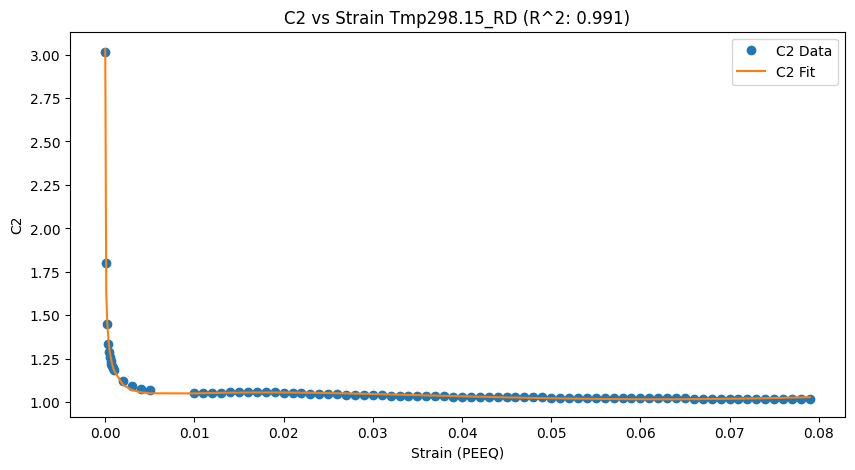

Parameters for C2: [-3.21676781e-01  1.56275235e+01  5.20886844e-01 -7.25959453e+00
  5.31261721e-01  8.51371965e+04 -2.32645021e+00]


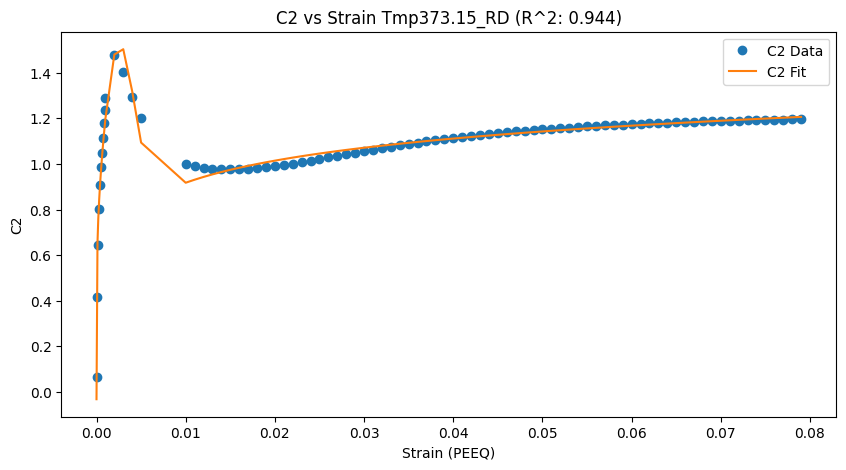

Parameters for C2: [ 0.13995611 -0.00776961  0.91340001  1.56202303 -0.00179749  0.80351945
  0.00235938]


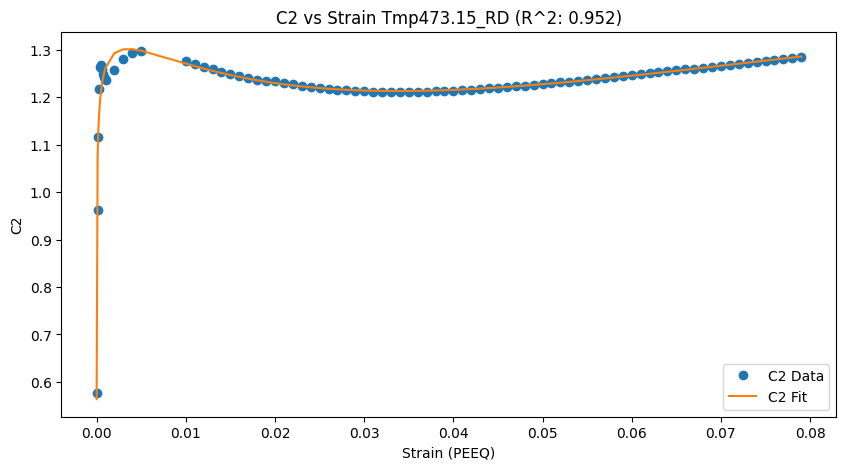

Parameters for C2: [ 1.11558268e-01 -1.20009107e+02  9.10650539e-01  4.95280493e+01
 -7.54585998e-01 -2.35024209e+02 -1.35009068e+00]


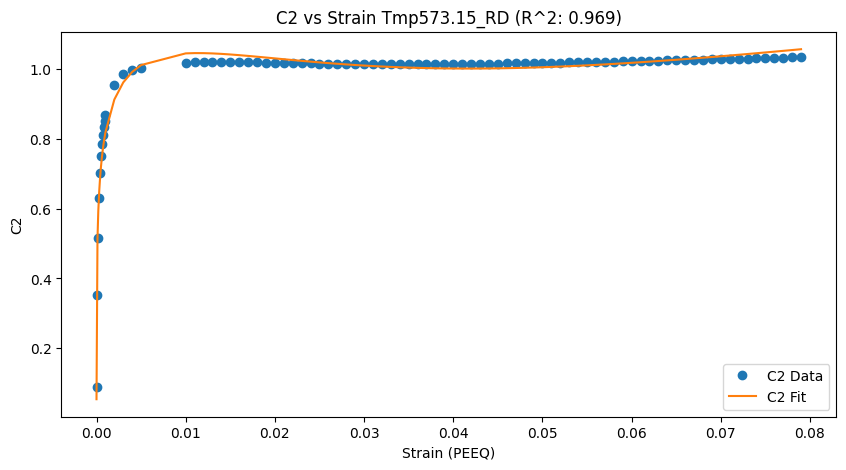

Parameters for C2: [-9.57165839e-02  6.17793316e+00  6.88737025e-02 -4.44089620e+00
  1.02692513e-01  1.04795115e+03 -3.89528534e-01]


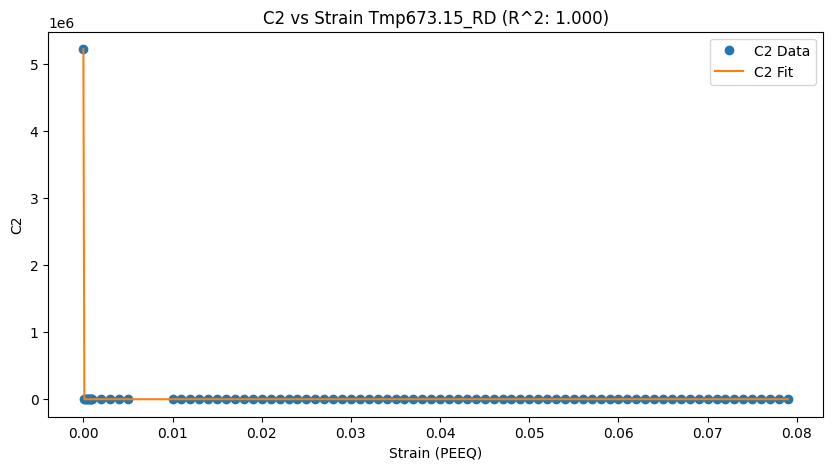

Parameters for C2: [-7.47900584e-02  5.12395512e-11 -2.83475537e+00 -1.13393423e-03
  7.07189764e+01  8.41863802e-01 -2.17762153e+01]


In [30]:
#temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD'] 

# Loop through each temperature file and plot C1 and C2 against strain (PEEQ)
for temp_file in temperature_files:
    calibrate_strain_dependent(temp_file)

# Validate stress

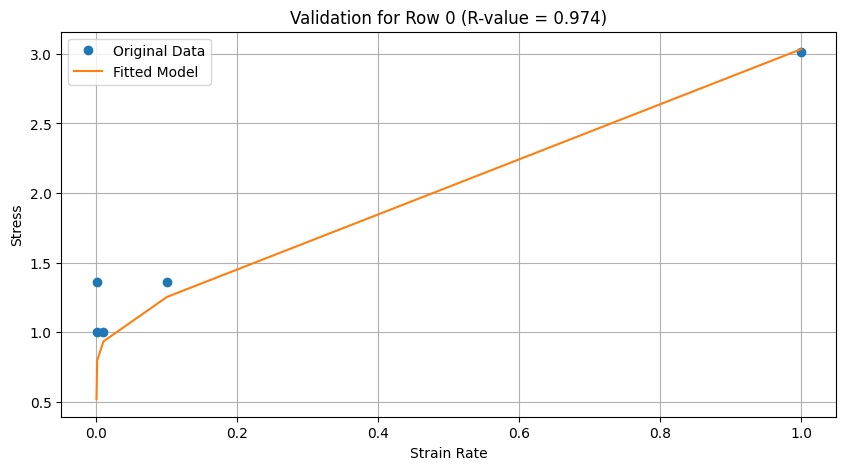

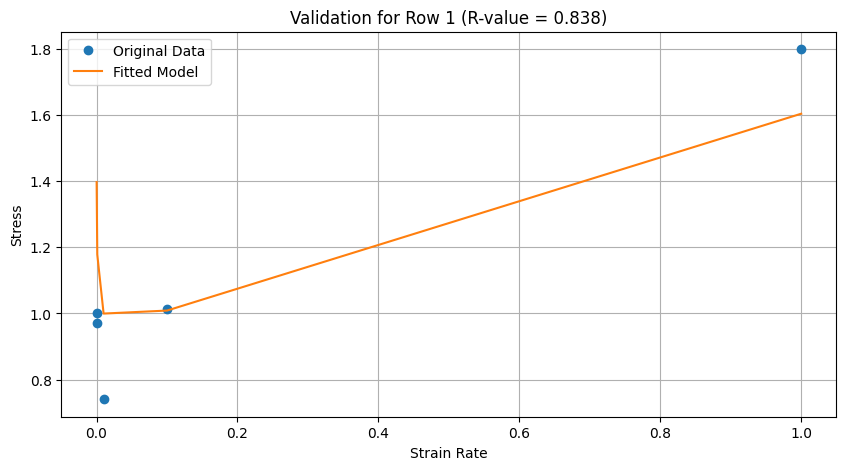

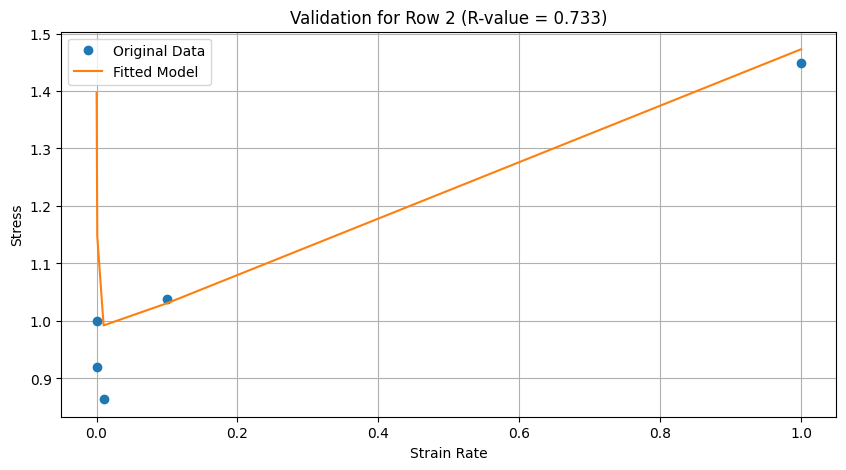

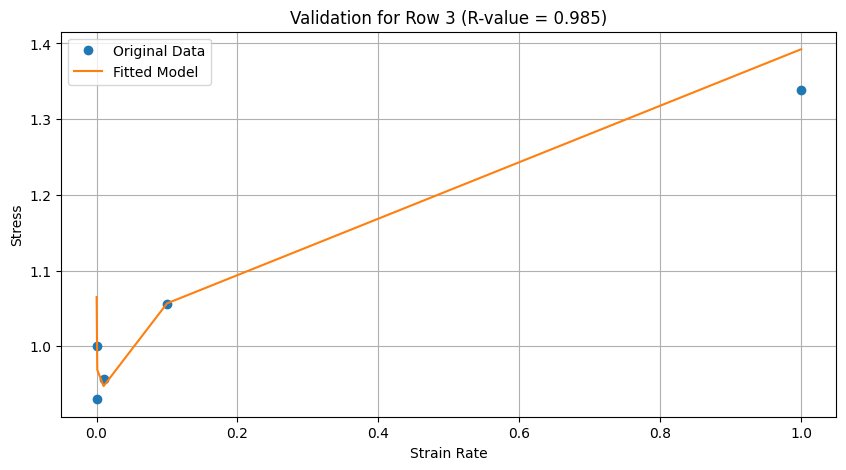

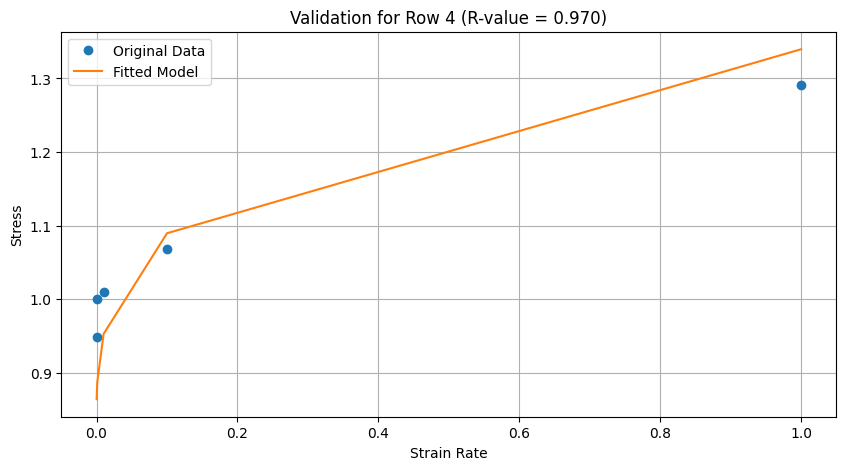

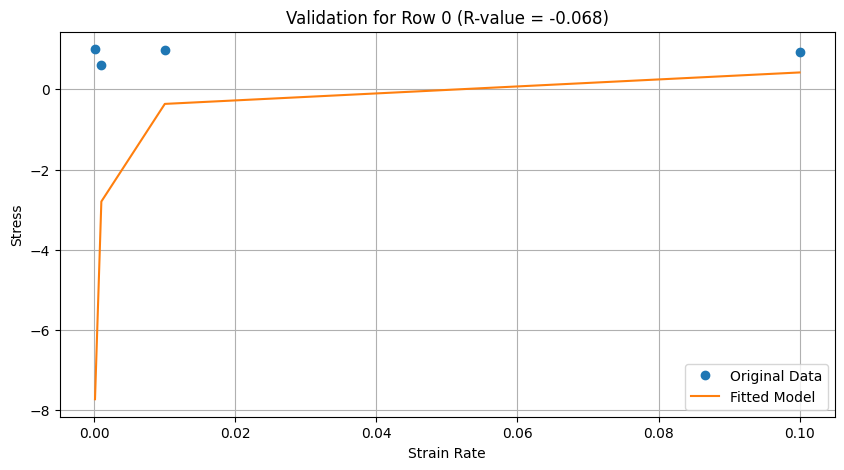

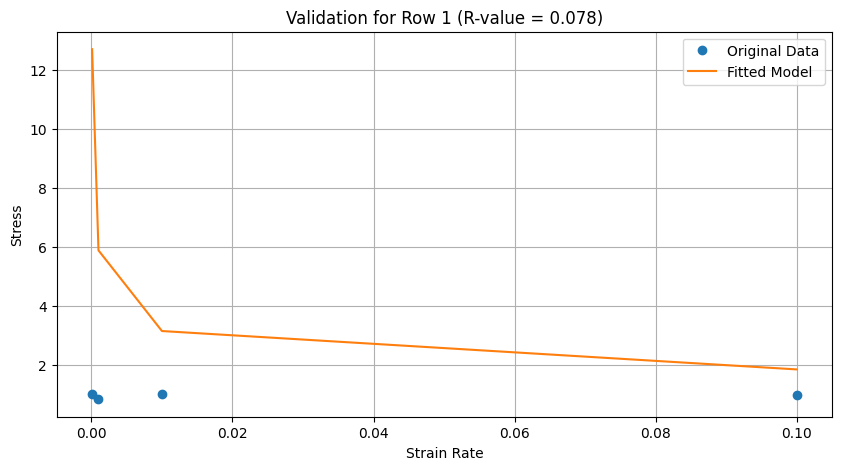

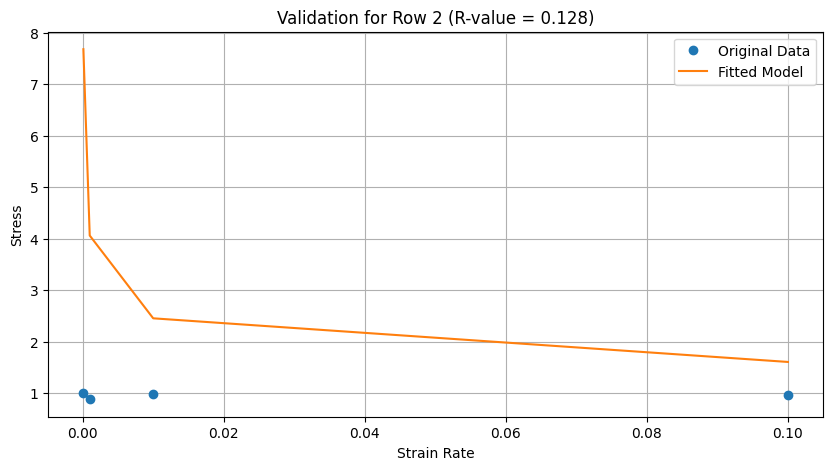

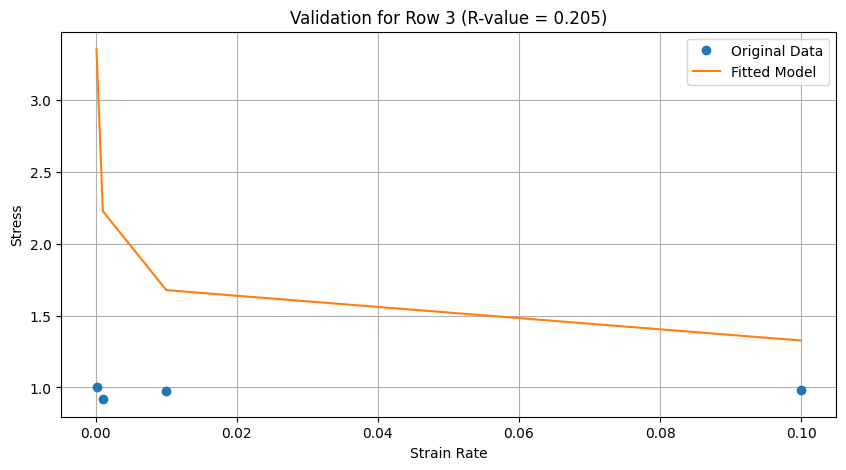

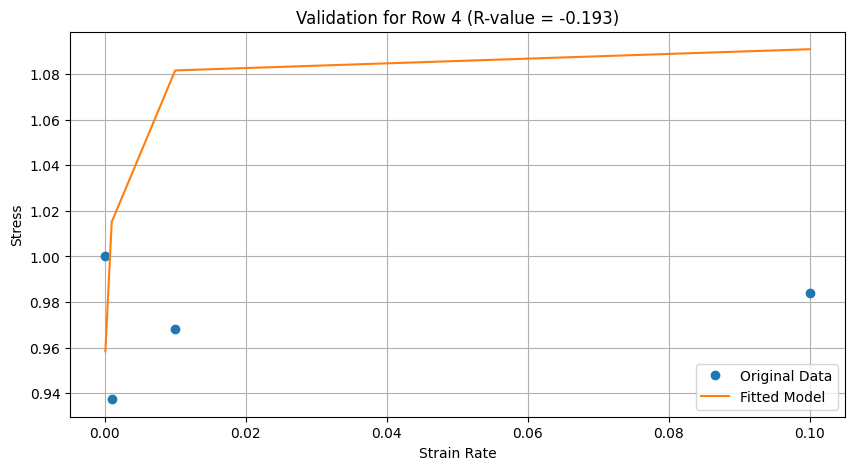

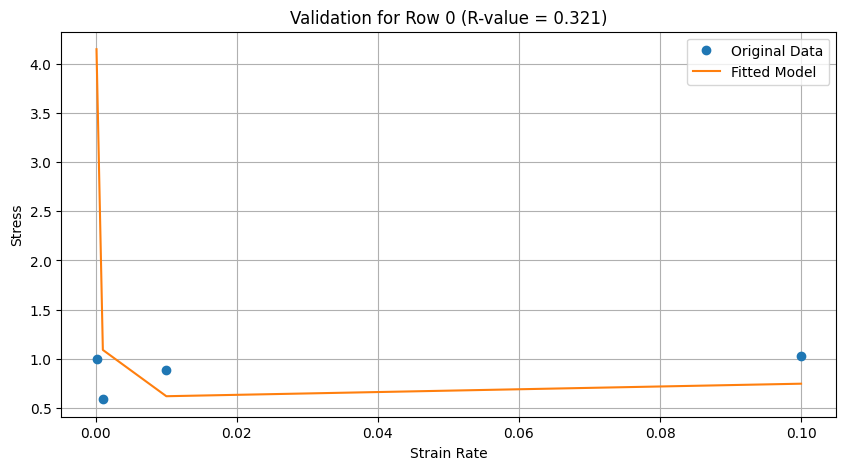

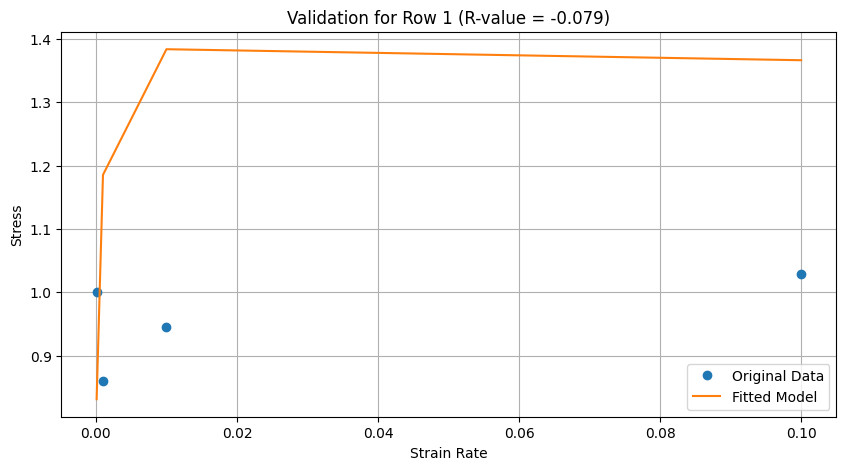

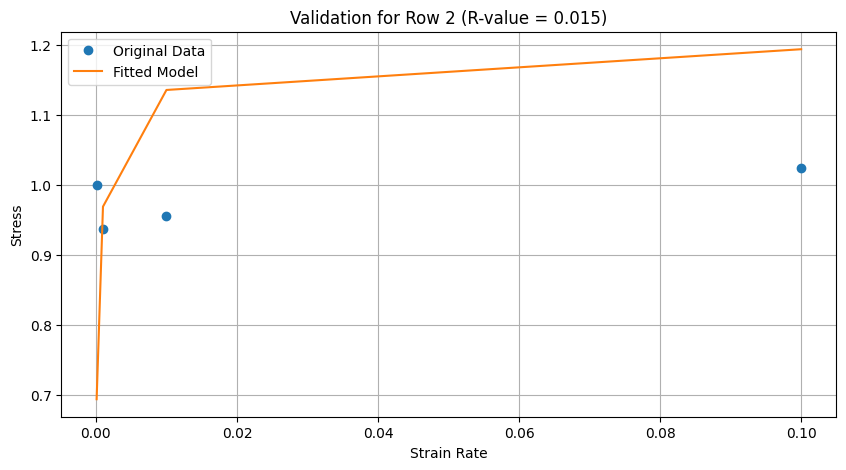

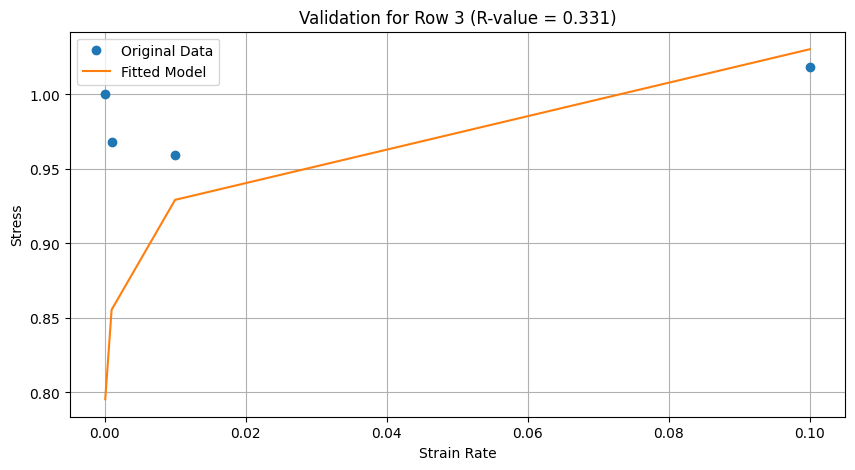

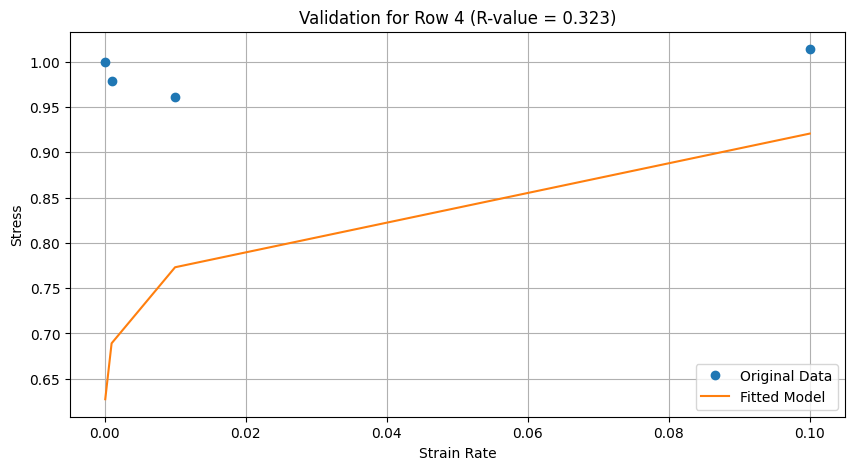

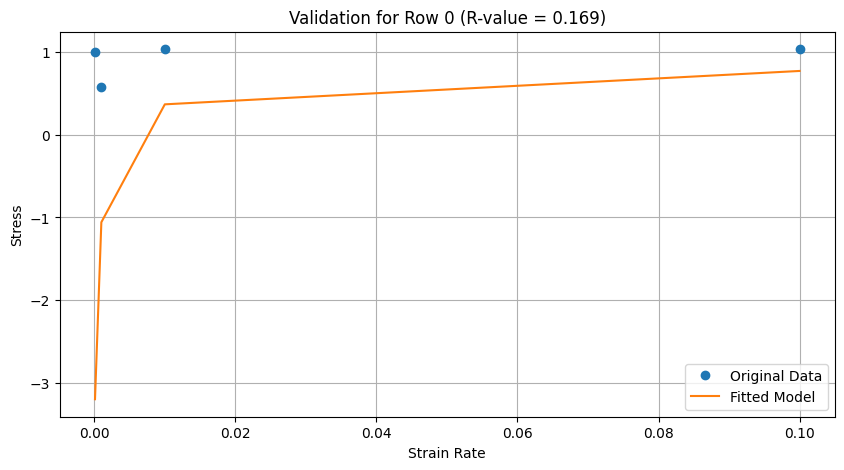

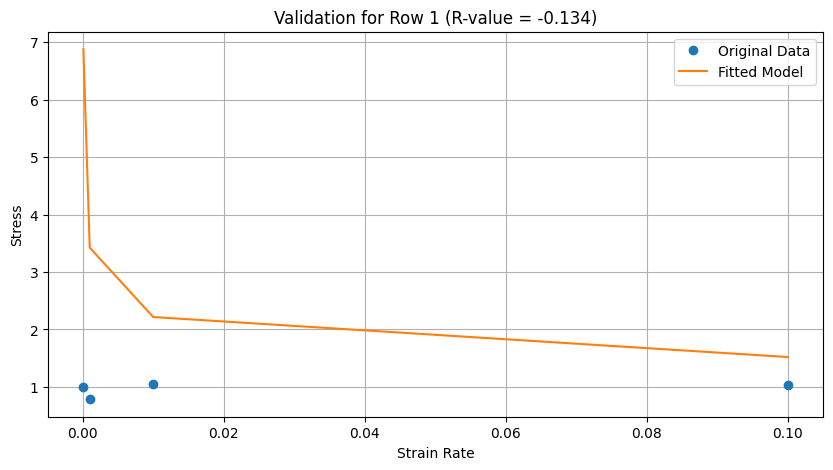

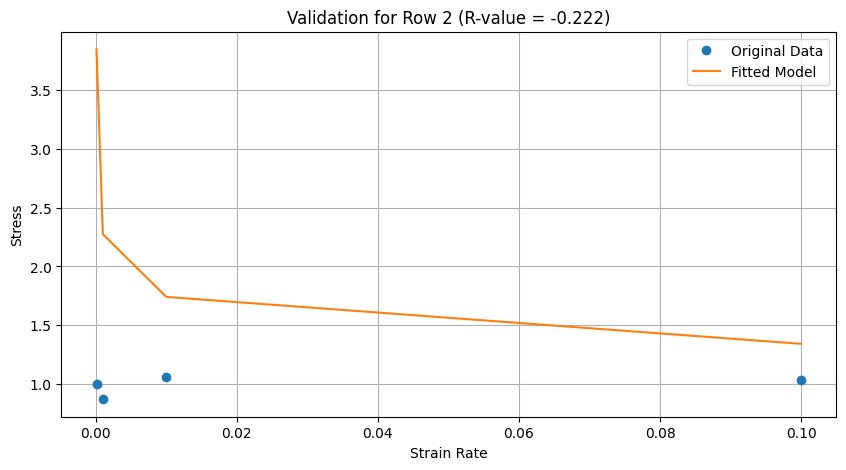

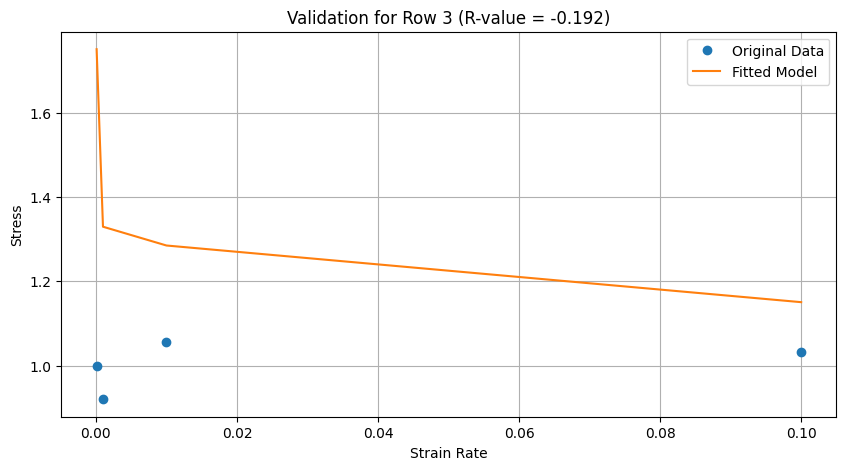

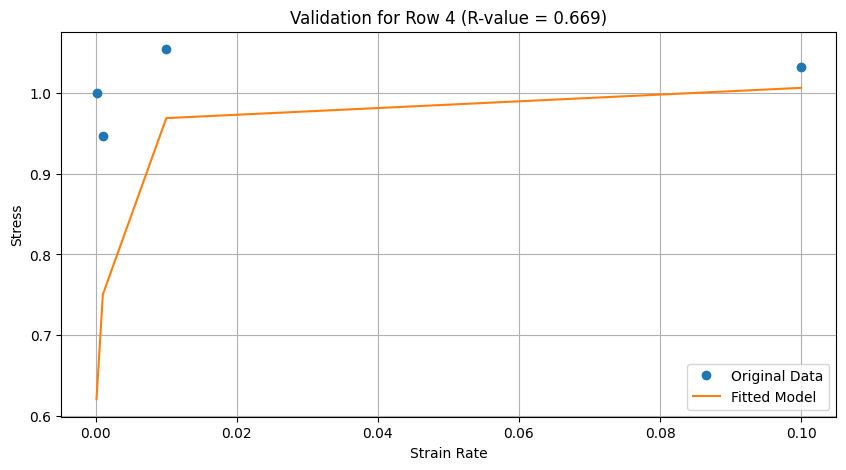

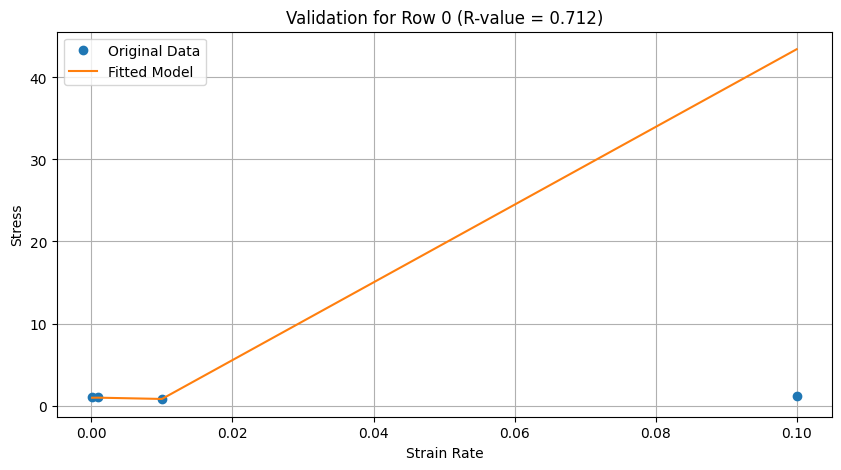

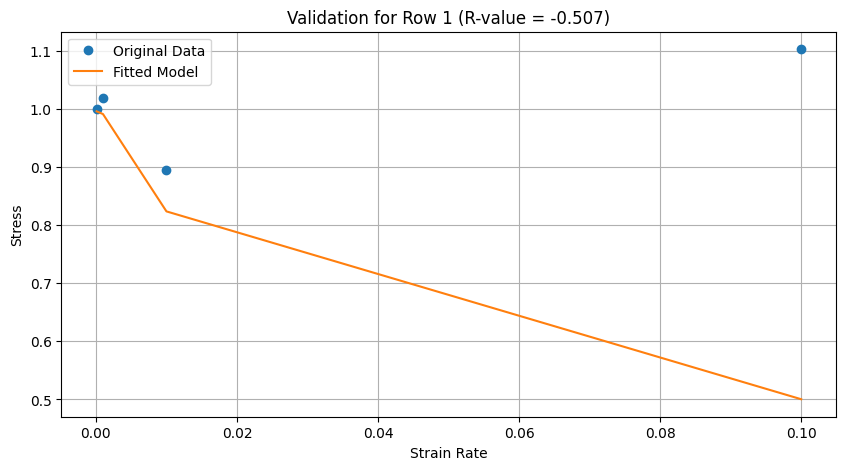

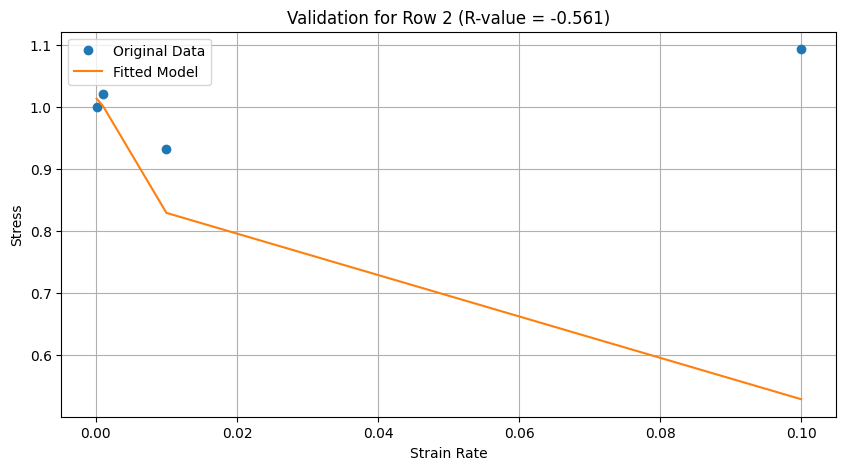

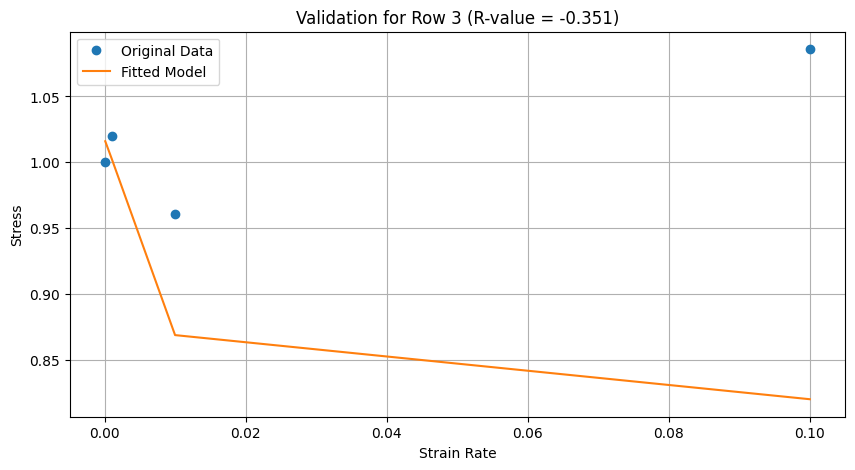

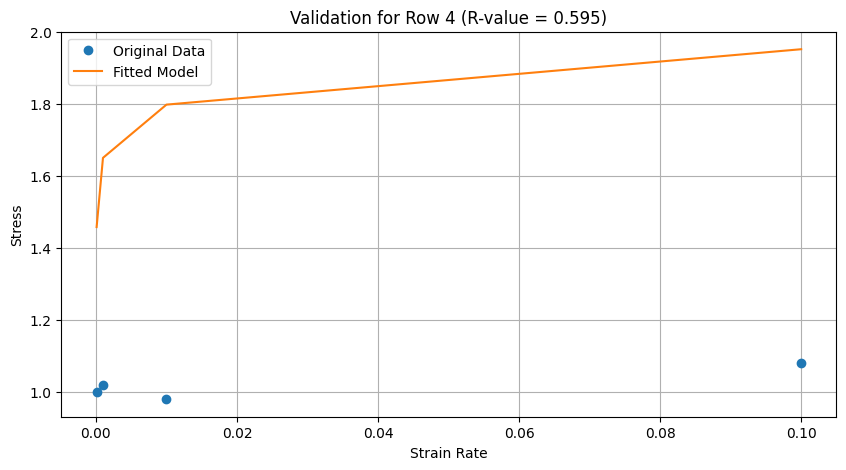

In [39]:
from scipy.stats import pearsonr

def validate_original_function(temperature_file, strain_rates, strain_rate_columns, max_plots=5):
    """Validates the original function using the fitted parameters and calculates R-value."""
    # Load the original data and the fitted parameters
    data = pd.read_csv(f"../{temperature_file}.csv")
    params_df = pd.read_csv(f"Fitted_Parameters_{temperature_file}.csv")
    
    r_values_list = []  # List to store R-values for each row
    plot_count = 0

    for i in range(len(data)):
        # Extract the parameters and stress data for comparison
        C1, C2, C3, C4 = params_df.iloc[i][['C1', 'C2', 'C3', 'C4']]
        stress_values = data.iloc[i][strain_rate_columns]

        # Compute stress from the original function
        fitted_stress = strain_rate_dependent_stress(np.array(strain_rates), C1, C2, C3, C4)

        # Calculate the R-value (correlation coefficient)
        r_value, _ = pearsonr(stress_values, fitted_stress)
        r_values_list.append({'Row': i, 'R-value': r_value})

        # Plot only a limited number of rows for visual validation
        if plot_count < max_plots:
            plt.figure(figsize=(10, 5))
            plt.plot(strain_rates, stress_values, 'o', label='Original Data')
            plt.plot(strain_rates, fitted_stress, '-', label='Fitted Model')
            plt.xlabel('Strain Rate')
            plt.ylabel('Stress')
            plt.title(f'Validation for Row {i} (R-value = {r_value:.3f})')
            plt.legend()
            plt.grid()
            plt.show()
            plot_count += 1

    # Save R-values to CSV
    r_values_df = pd.DataFrame(r_values_list)
    r_values_df.to_csv(f"R_values_{temperature_file}.csv", index=False)

# Example usage:
temperature_file = 'Tmp298.15_RD'
strain_rates = [0.0001, 0.001, 0.01, 0.1, 1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1', 'ref_StrRt1']
validate_original_function(temperature_file, strain_rates, strain_rate_columns)

temps = ['373.15', '473.15', '573.15', '673.15']
strain_rates = [0.0001, 0.001, 0.01, 0.1]
strain_rate_columns = ['ref_StrRt0.0001', 'ref_StrRt0.001', 'ref_StrRt0.01', 'ref_StrRt0.1']
for temp in temps:
    validate_original_function(f"Tmp{temp}_RD", strain_rates, strain_rate_columns)

In [40]:
def check_r_squared(temperature_files):
    """
    Checks R_squared values in the Parameters file for each temperature and reports the count
    and percentage of rows with R_squared below a specified threshold.
    
    Parameters:
    - temperature_files (list of str): List of temperature file names (without ".csv" extension).
    
    Output:
    - Prints the count and percentage of rows with R_squared < threshold for each temperature file.
    """
    threshold = 0.85
    for temp_file in temperature_files:
        # Load the data from the CSV file
        df = pd.read_csv(f"R_values_{temp_file}.csv")
        
        # Count rows where R_squared is less than the threshold
        total_rows = len(df)
        count_low_r_squared = df[df['R-value'] < threshold].shape[0]
        
        # Calculate the percentage of rows with low R_squared
        percentage_low_r_squared = (count_low_r_squared / total_rows) * 100 if total_rows > 0 else 0
        
        # Print results
        print(f"\nTemperature File: Parameters_{temp_file}.csv")
        if count_low_r_squared > 0:
            print(f"Number of rows with R_squared < {threshold}: {count_low_r_squared}")
            print(f"Percentage of rows with R_squared < {threshold}: {percentage_low_r_squared:.2f}%")
        else:
            print(f"All R_squared values are >= {threshold}.")

# Usage
temperature_files = ['Tmp298.15_RD', 'Tmp373.15_RD', 'Tmp473.15_RD', 'Tmp573.15_RD', 'Tmp673.15_RD']  # List of temperature files to check
check_r_squared(temperature_files)



Temperature File: Parameters_Tmp298.15_RD.csv
Number of rows with R_squared < 0.85: 25
Percentage of rows with R_squared < 0.85: 29.41%

Temperature File: Parameters_Tmp373.15_RD.csv
Number of rows with R_squared < 0.85: 70
Percentage of rows with R_squared < 0.85: 82.35%

Temperature File: Parameters_Tmp473.15_RD.csv
Number of rows with R_squared < 0.85: 11
Percentage of rows with R_squared < 0.85: 12.94%

Temperature File: Parameters_Tmp573.15_RD.csv
Number of rows with R_squared < 0.85: 19
Percentage of rows with R_squared < 0.85: 22.35%

Temperature File: Parameters_Tmp673.15_RD.csv
Number of rows with R_squared < 0.85: 13
Percentage of rows with R_squared < 0.85: 15.29%
